# Computer Assignment 3

This is an all-in-one report to 6123 IVP, where the explanations, discussions and codes are included.

All experiments are run in Python code.

Import all libs we need

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import time
import pywt

from numpy import linalg as LA

from matplotlib import rcParams
from matplotlib import rc
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.special import comb
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pi = np.pi
%matplotlib inline

## 1 & 2. ISTA Algorithm & DCT transformation

Implement ISTA algorithm.

ISTA algorithm is used to solve L1 regularization problem, also called LASSO problem. It is formulated as follow:

$$\underset{x}{\mathop{\min }}\,\left[ J\left( \mathbf{x} \right)=\left\| \mathbf{y}-\mathbf{Hx} \right\|_{2}^{2}+\lambda {{\left\| \mathbf{x} \right\|}_{1}} \right]$$

Its iteration format is:

$${{\mathbf{x}}_{k+1}}=\text{soft}\left( {{\mathbf{x}}_{k}}+\frac{1}{\alpha }{{\mathbf{H}}^{\top}}\left( \mathbf{y}-\mathbf{Hx} \right),\frac{\lambda }{\alpha } \right),\alpha \ge \text{maxeig} \left( {{\mathbf{H}}^{\top}}\mathbf{H} \right)$$

In [2]:
def soft(x, T):
    return np.minimum(x + T, 0) + np.maximum(x - T, 0)

def J(y, H, x, lamb):
    return LA.norm(y - H @ x, 2) ** 2 + lamb * LA.norm(x, 1)

def ISTA(y, H, lamb, err=1e-7, steps=1e3):
    '''
    solve such a LASSO problem:
        min with parameter x: J(x) = norm(y - H * x, 2) ^ 2 + lamb * norm(x, 1)
    where:
        y: vector with shape of (m,)
        H: dict matrix with shape of (m,n)
        x: vector with shape of (n,)
        lamb: LASSO regularization
    
    Iteration format is defined as:
    x' = soft(x + 1 / alpha * H.T * (y - H * x), lamb / alpha / 2)
    
    return:
    x: optimum vector x
    J: optimum cost J
    Itr: # iterations
    '''
    [m,n] = np.shape(H)
    # 10 times random initialization
    x_opt = np.random.rand(n)
    J_opt = J(y, H, x_opt, lamb)
    '''
    for _ in range(10):
        x1 = np.random.rand(n)
        J1 = J(y, H, x1, lamb)
        if J_opt > J1:
            x_opt = x1
            J_opt = J1
    '''
    # initialize iteration
    Itr = 0
    alpha = np.max(LA.eig(H.T @ H)[0])
    
    J0 = J_opt
    J1 = J0 * err * 10
    x0 = np.zeros(n) + x_opt
    x1 = np.zeros(n) + x_opt
    
    # iterating
    while (np.abs((J0 - J1) / J0) >= err) & (Itr < steps):
        x0 = x1
        J0 = J1
        x1 = soft(x0 + 1 / alpha * H.T @ (y - H @ x0), lamb / alpha / 2)
        J1 = J(y, H, x1, lamb)
        Itr += 1
    
    return x1, J1, Itr

Implement DCT basis generation function. It is defined as:

$${{h}_{k}}\left( n \right)=\alpha \left( k \right)\cos \left[ \frac{\left( 2n+1 \right)k\pi }{2N} \right],\alpha \left( k \right)=\left\{ \begin{array}{*{35}{l}}
   \sqrt{{1}/{N}\;} & k=0  \\
   \sqrt{{2}/{N}\;} & k=1,\ldots ,N-1  \\
\end{array} \right.$$


In [3]:
def DCT_basis_gen(N):
    '''
    N dimension DCT basis generator
    return:
    H: DCT basis with shape of (N,N)
    '''
    H = np.cos(np.pi / 2 / N * (np.linspace(0,N-1,N)[None,:] * np.linspace(1,2*N-1,N)[:,None]))
    H = np.hstack((np.sqrt(1 / N), np.linspace(np.sqrt(2 / N),np.sqrt(2 / N), N - 1)))[None,:] * H 
    return H
    

In [4]:
# show 4D DCT basis
print(DCT_basis_gen(4))

[[ 0.5         0.65328148  0.5         0.27059805]
 [ 0.5         0.27059805 -0.5        -0.65328148]
 [ 0.5        -0.27059805 -0.5         0.65328148]
 [ 0.5        -0.65328148  0.5        -0.27059805]]


Implement enoise function using given SNR. SNR for 1D discrete signal is defined as:

$$\text{SNR}=10{{\log }_{10}}\left( \frac{{{P}_{s}}}{{{P}_{n}}} \right)=10{{\log }_{10}}\left( \frac{\sum\limits_{i}{{S}\left( i \right)}}{\sum\limits_{i}{{N}\left( i \right)}} \right)$$

In [5]:
def snr(x,x_n):
    '''
    Calculate SNR:
    input:
    x: original signal
    x_n: noised signal
    return:
    SNR: SNR
    '''
    return 10 * np.log10(np.sum(x ** 2) / np.sum((x-x_n) ** 2))

def noise(x,SNR):
    '''
    add Guassian noise with SNR input on signal x
    SNR = 10*log10(P_s/P_n)=10*log10(sum(s^2)/sum(n^2))
    return:
    y: noised x
    '''
    Pn = np.sum(x ** 2) / 10 ** (SNR / 10)
    n = np.random.normal(0,1,x.shape)
    y = x + n * np.sqrt(Pn / np.sum(n ** 2))
    return y

In [6]:
H_16 = DCT_basis_gen(16)
x = np.hstack((np.random.rand(4),np.zeros(12)))
np.random.shuffle(x)
x = x / LA.norm(x,2) * 10
y = H_16 @ x
y_n = noise(y,10)
print("coefficients x:\n", x, "\n")
print("energy of y:", np.sum(y**2), "\n")
print("noised signal y:\n", y_n, "\n")
print("SNR:", snr(y,y_n), "dB")

coefficients x:
 [ 0.          0.          0.          3.09240261  0.          3.70501208
  0.          0.          0.          0.          4.39895898  0.
  7.57357851  0.          0.          0.        ] 

energy of y: 100.0 

noised signal y:
 [ 4.41113082 -2.99374332  0.93195084 -1.90777511 -5.03902686  1.4291026
 -0.3907639   1.22165312 -1.43818886 -0.46009163  2.61304992 -0.0073181
  3.07593498  4.29086131 -3.79435009 -0.51685088] 

SNR: 10.0 dB


Generate a "random" 1D discrete noisy signal with SNR = `10,20,30,40dB` respectively.

For the purpose of test, fix the random number seed so that we get the same sequence each time we run the experiment.

In [7]:
# given SNR = 10,20,30,40 respectively
# given Lambda = 10^1,0,-1,-2 respectively
np.random.seed(23333)
X = []
Y = []
x = np.hstack((np.random.rand(4),np.zeros(12)))
np.random.shuffle(x)
for SNR in range(10,41,10):
    X.append(x / LA.norm(x,2) * 10)
    Y.append(noise(H_16 @ (X[-1]),SNR))
np.random.seed(int(time.time()))
Lambda = 10.0 ** np.arange(1,-3,-1) #1e1~1e-2

Using ISTA algorithm we implemented above to denoise the enoised signals

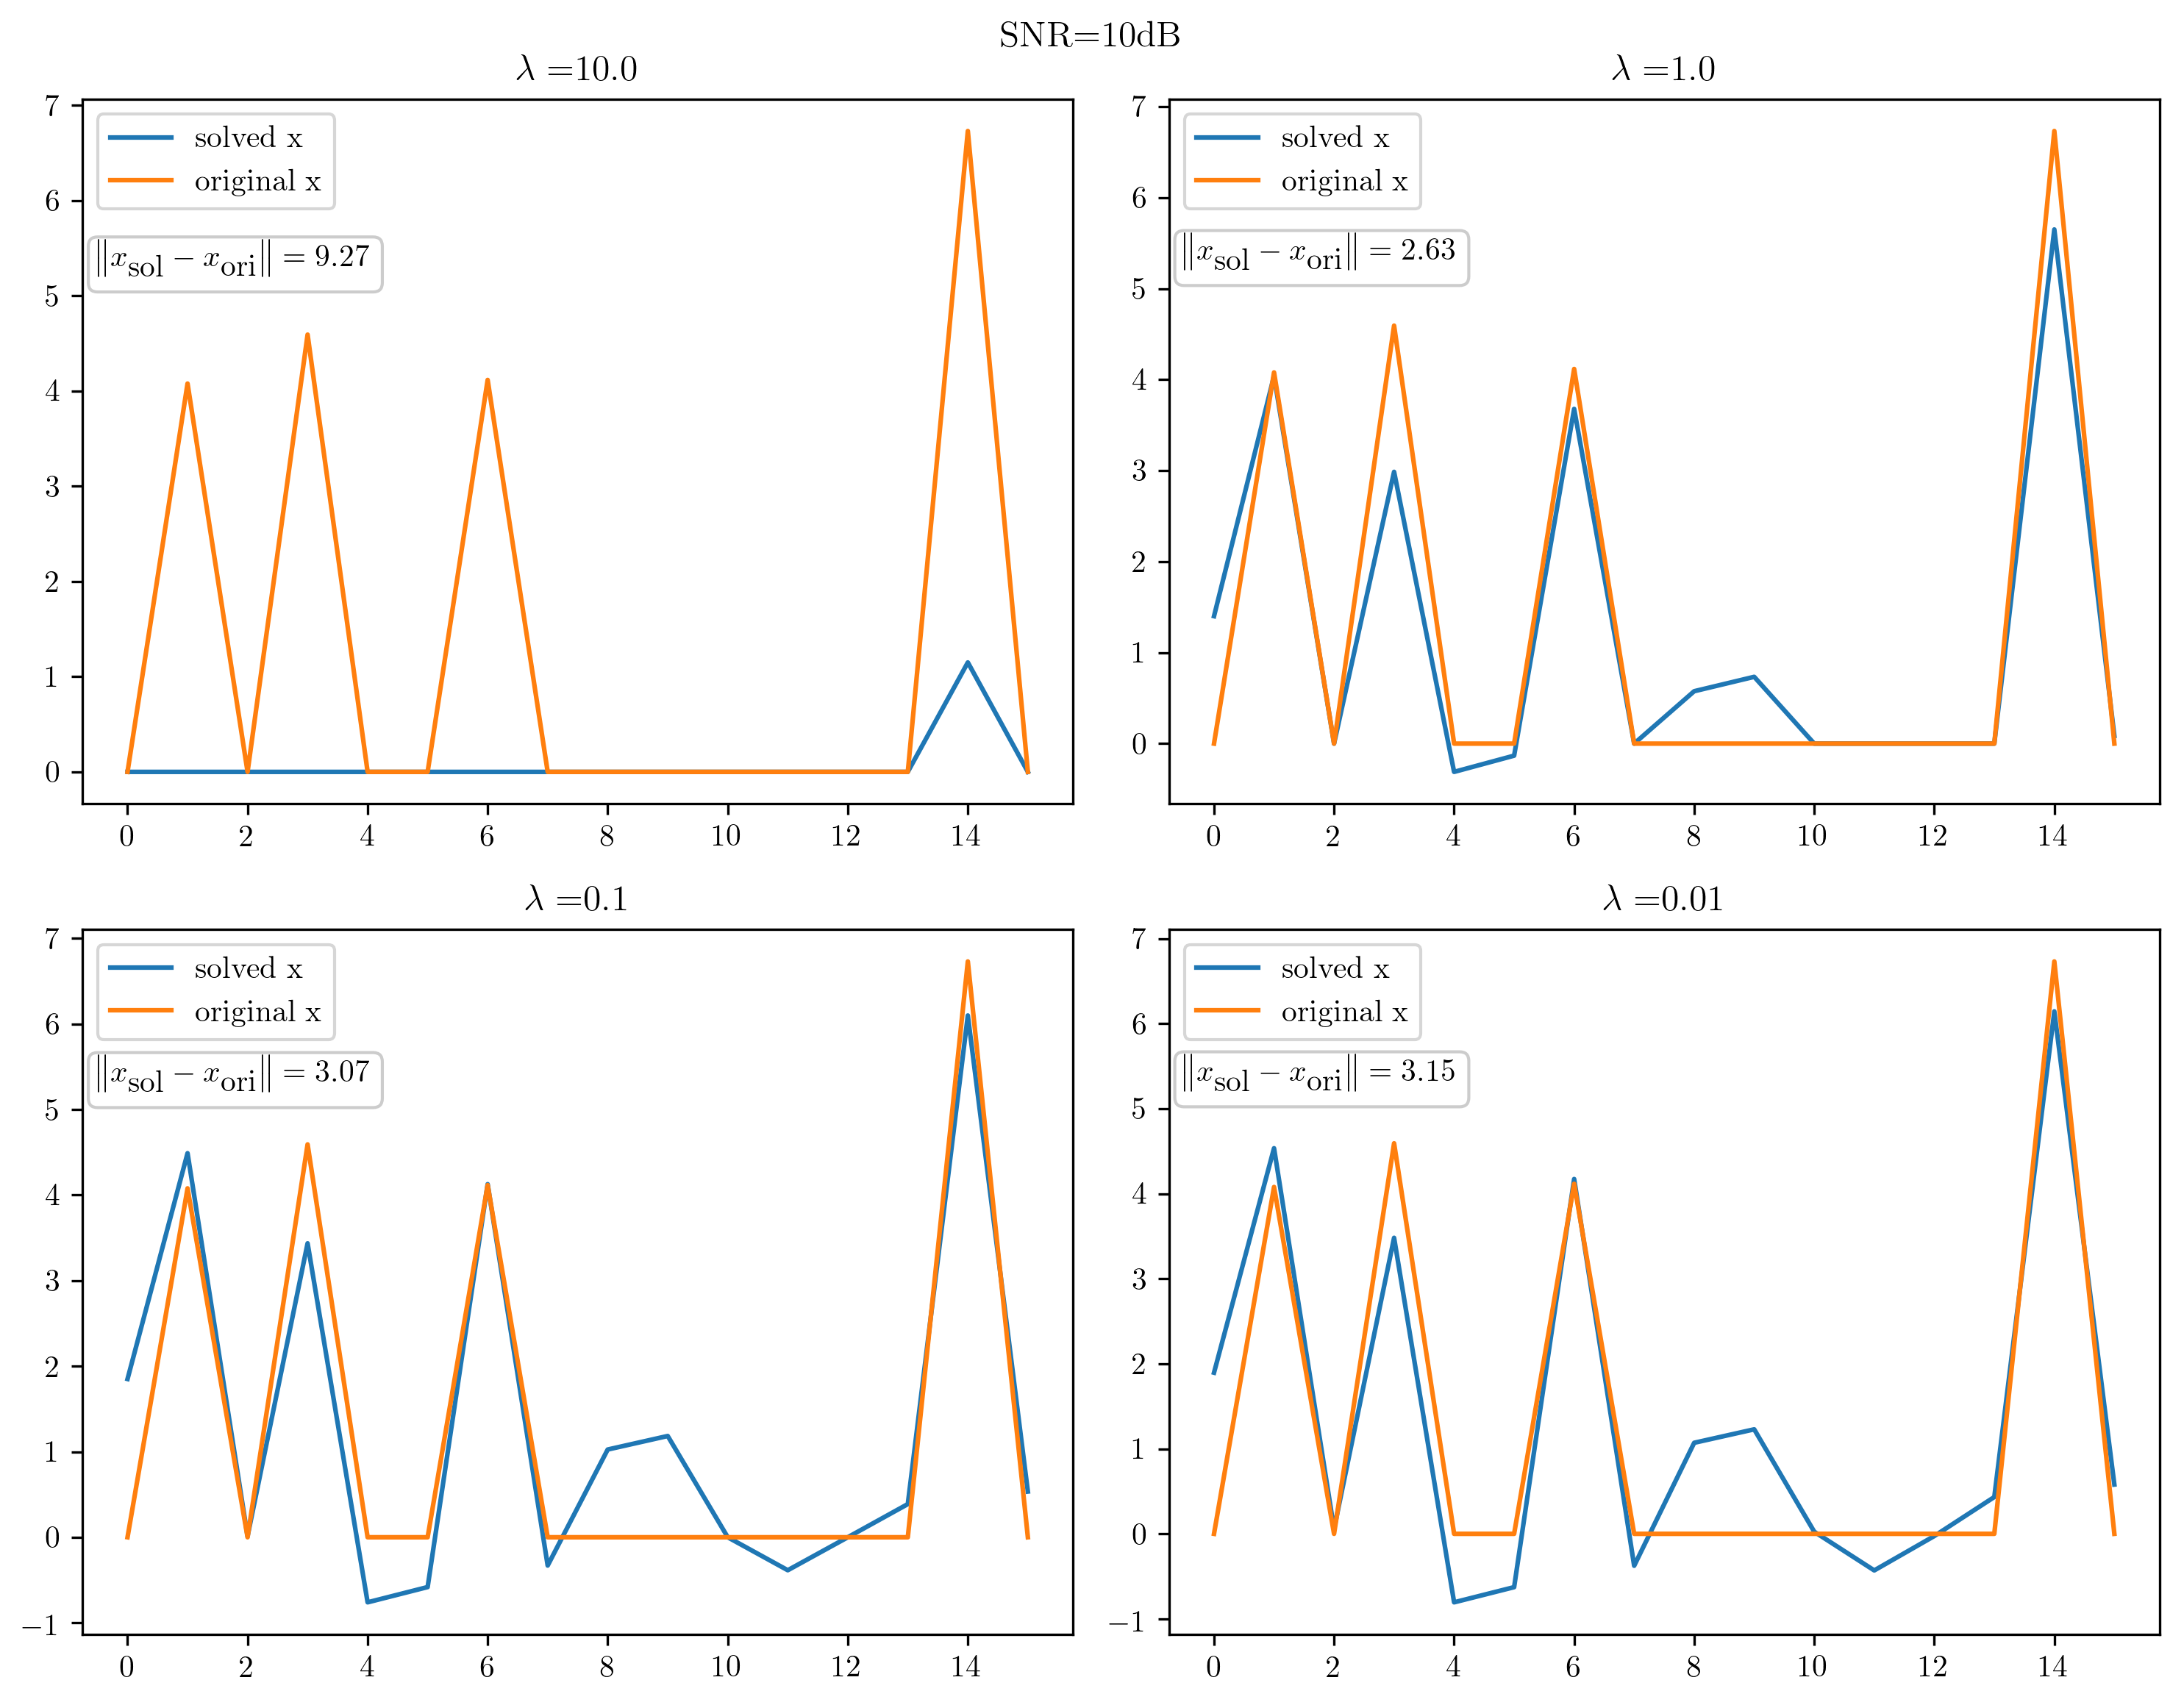

In [8]:
k = 0
y = Y[k]
x_std = X[k]
SNR_i = range(10,101,10)[k]
plt.figure(dpi=300,figsize=(10,8))
plt.suptitle("SNR="+str(SNR_i)+"dB")
for Id, il in enumerate(Lambda):
    plt.subplot(221+Id)
    x_re,_,_ = ISTA(y, H_16, lamb=il)
    plt.plot(range(16),x_re,label='solved x')
    plt.plot(range(16),x_std,label='original x')
    plt.text(-0.5,5.2,"$\\left\|{x}_{\\textup{sol}}-{x}_{\\textup{ori}}\\right\|="+'%.2f'%LA.norm(x_re-x_std,2)+"$",
             bbox=dict(boxstyle="round",
                   ec=(0.8, 0.8, 0.8),
                   fc=(1, 1, 1)))
    plt.title("$\lambda=$"+str(il))
    plt.legend(loc = 'upper left')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])

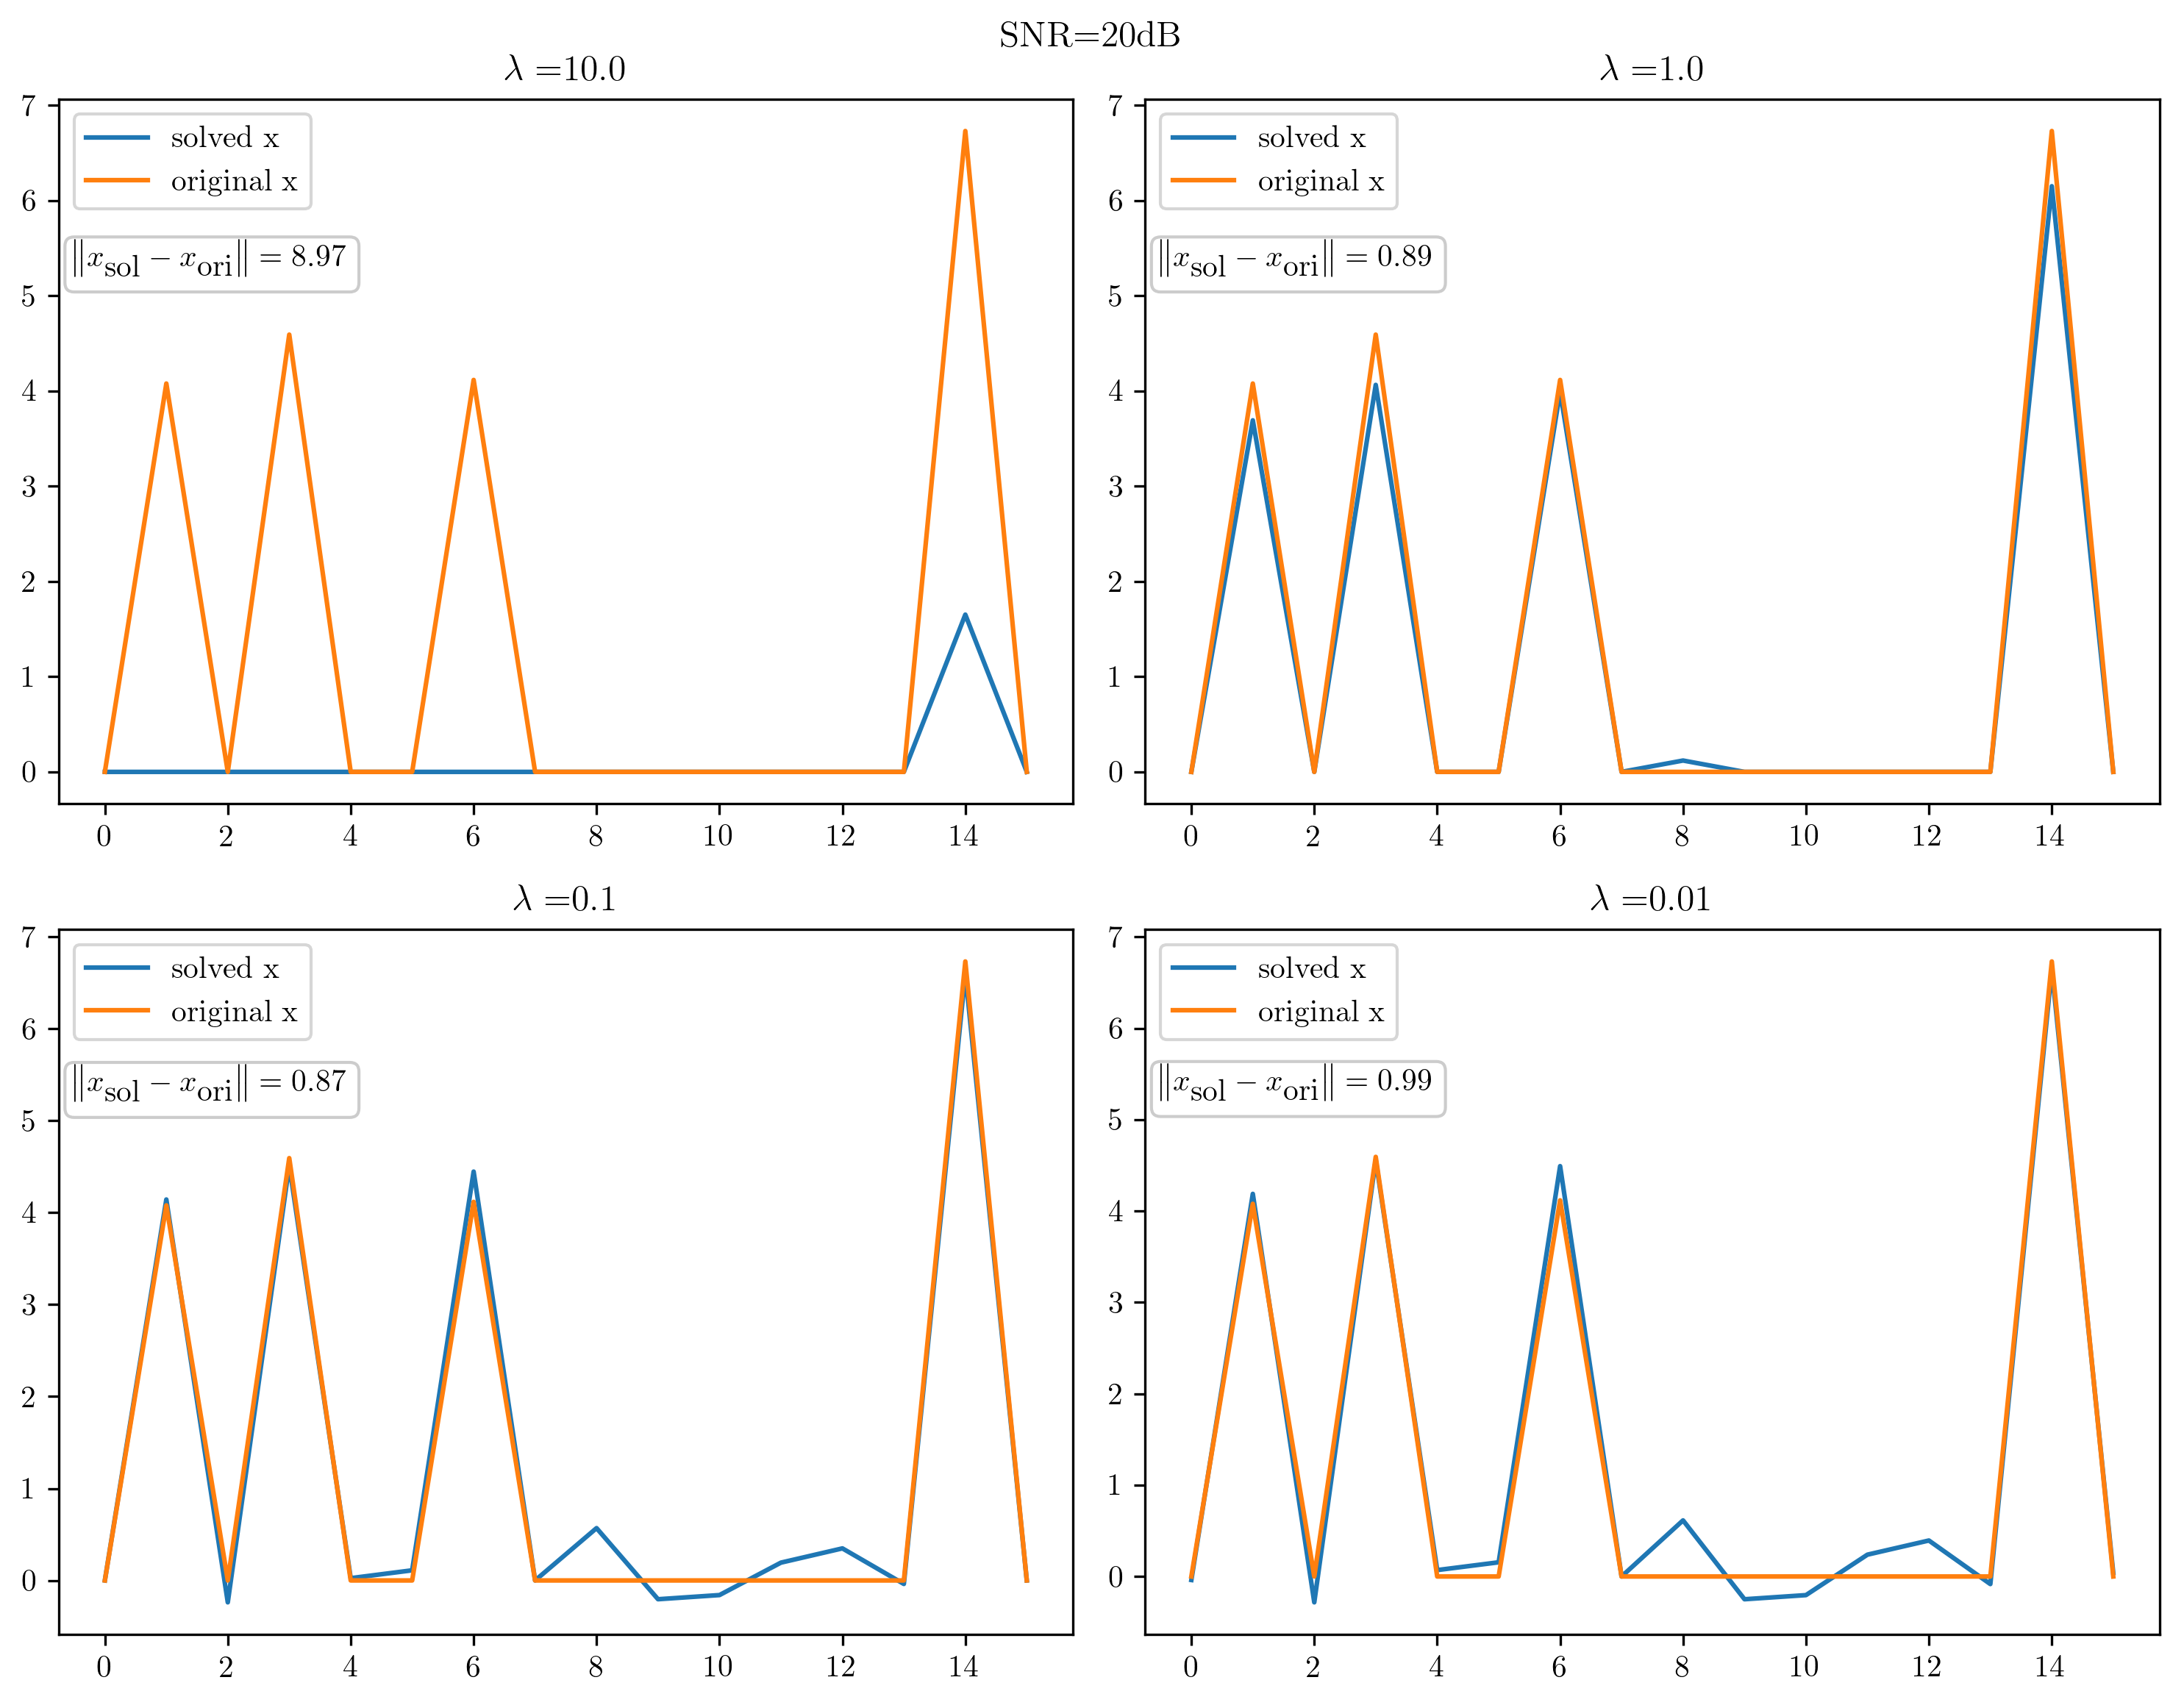

In [9]:
k = 1
y = Y[k]
x_std = X[k]
SNR_i = range(10,101,10)[k]
plt.figure(dpi=300,figsize=(10,8))
plt.suptitle("SNR="+str(SNR_i)+"dB")
for Id, il in enumerate(Lambda):
    plt.subplot(221+Id)
    x_re,_,_ = ISTA(y, H_16, lamb=il)
    plt.plot(range(16),x_re,label='solved x')
    plt.plot(range(16),x_std,label='original x')
    plt.text(-0.5,5.2,"$\\left\|{x}_{\\textup{sol}}-{x}_{\\textup{ori}}\\right\|="+'%.2f'%LA.norm(x_re-x_std,2)+"$",
             bbox=dict(boxstyle="round",
                   ec=(0.8, 0.8, 0.8),
                   fc=(1, 1, 1)))
    plt.title("$\lambda=$"+str(il))
    plt.legend(loc = 'upper left')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])

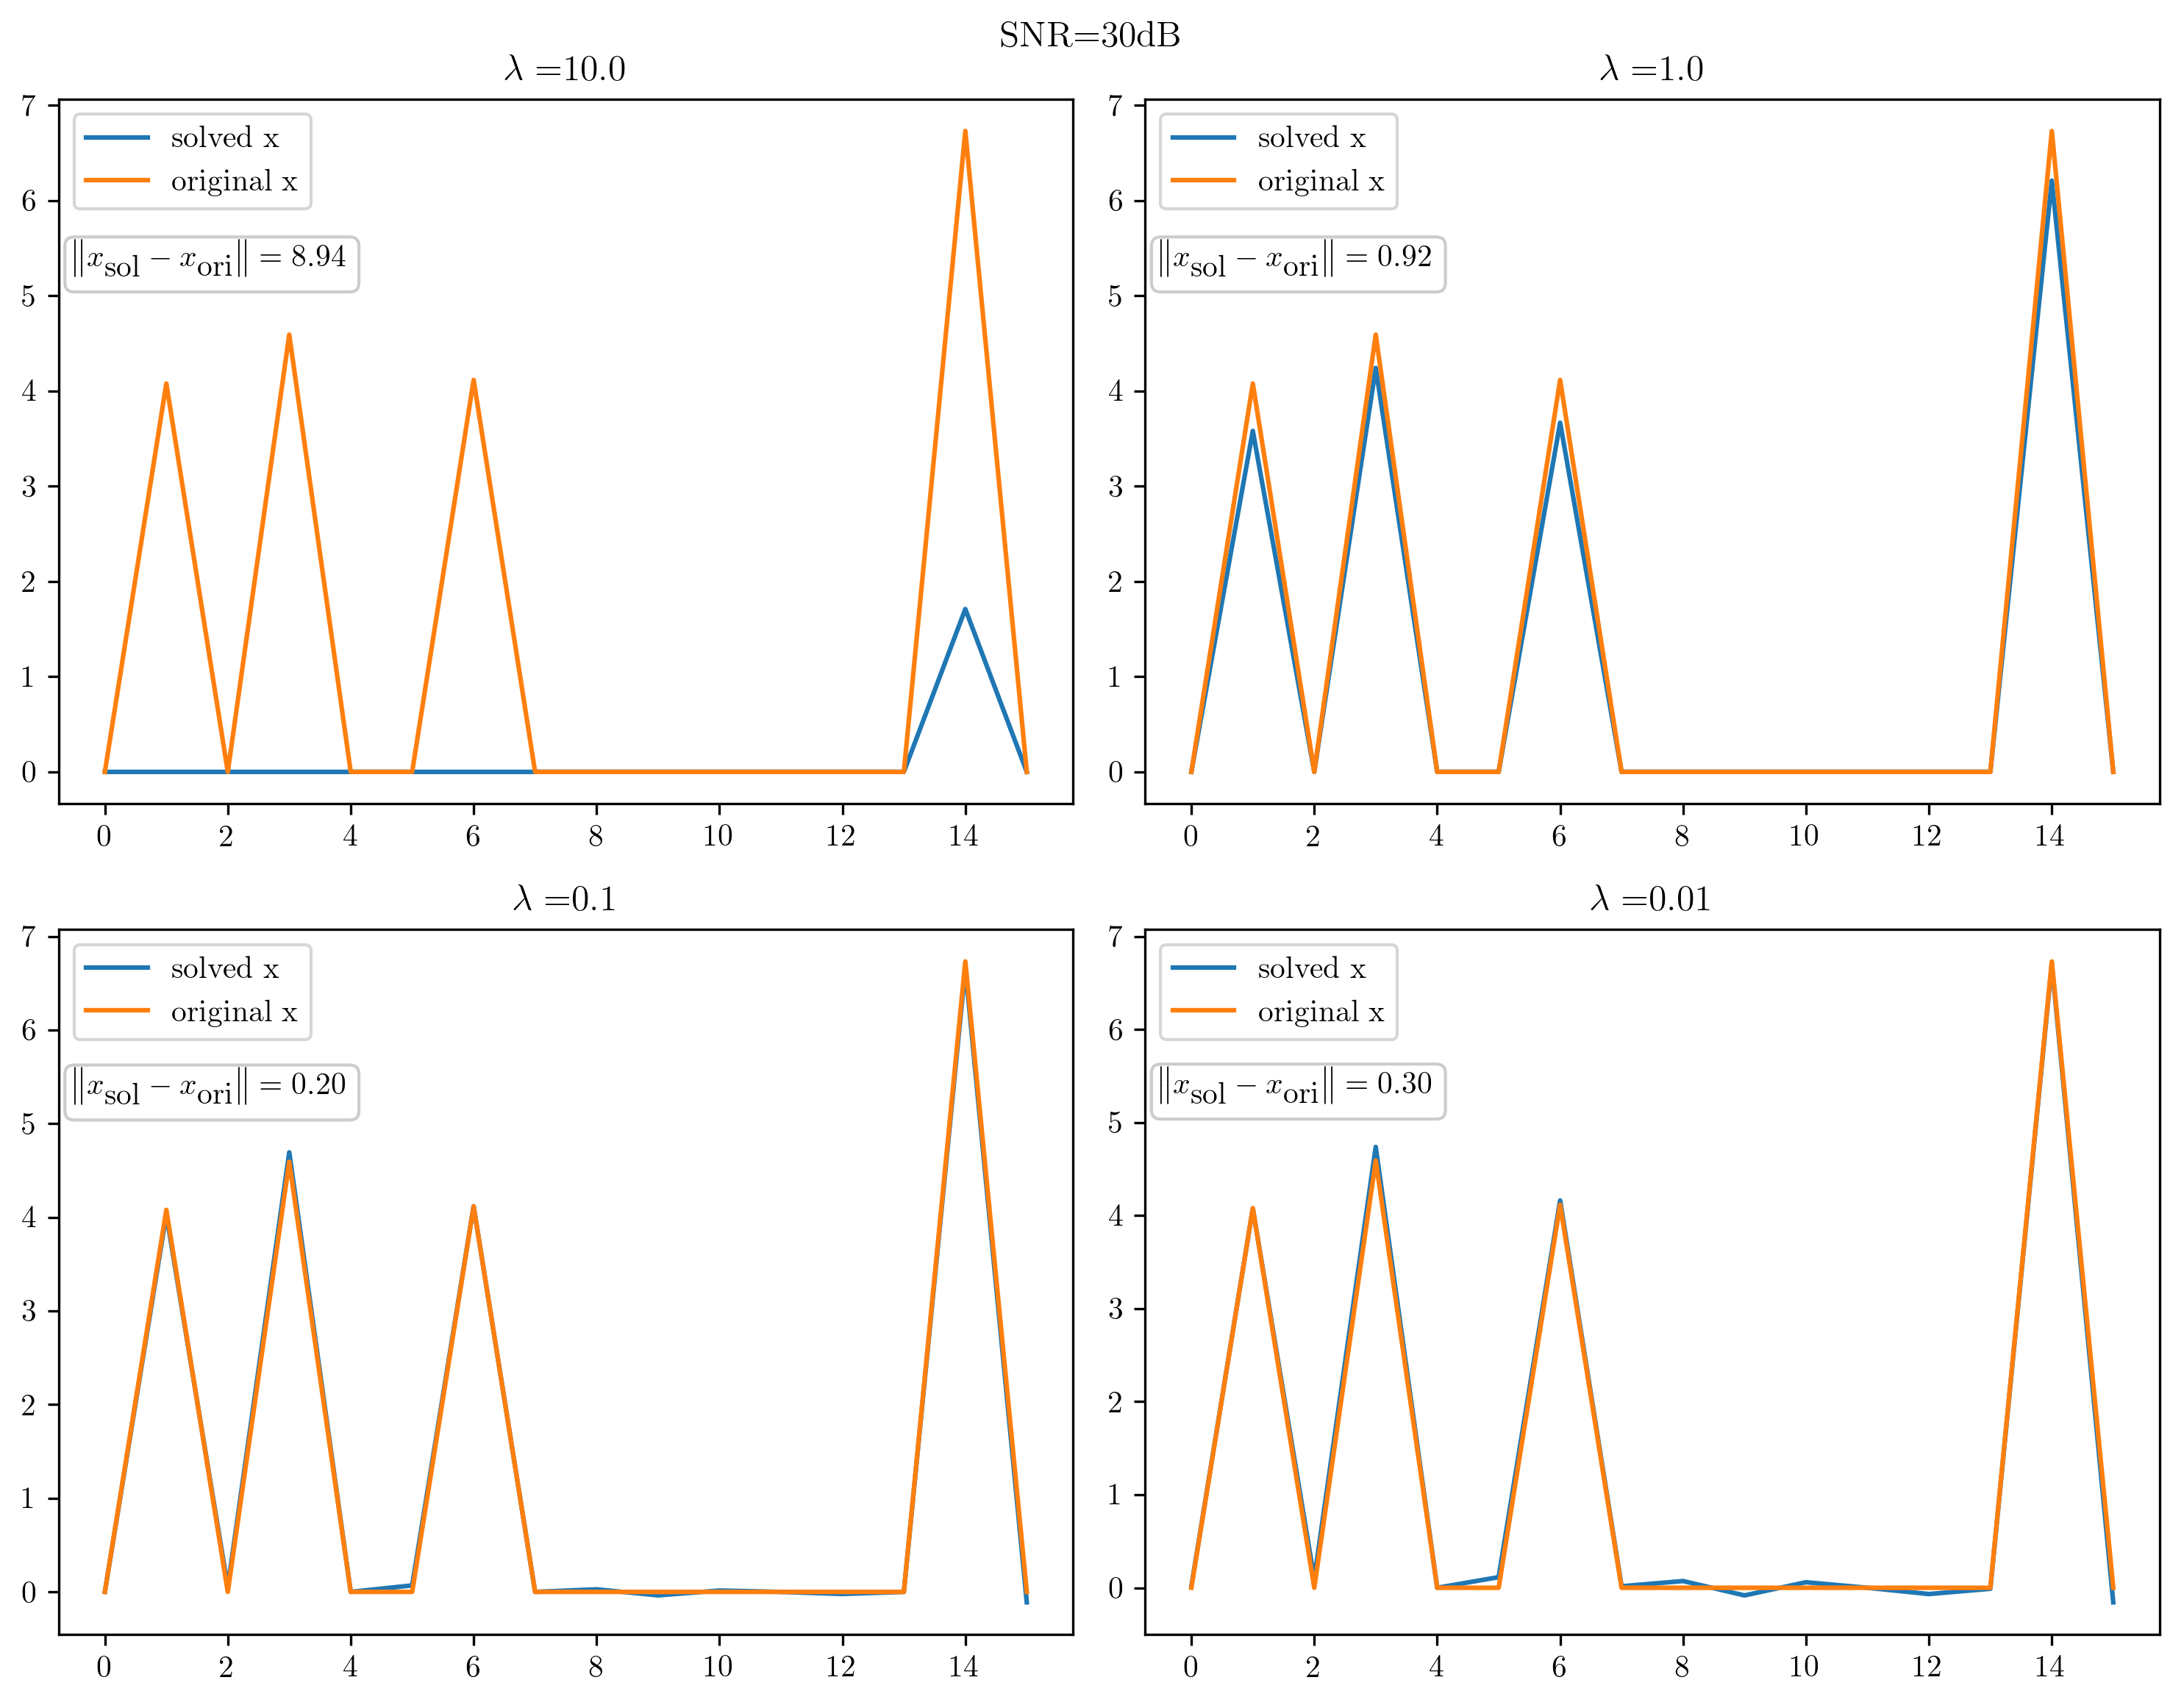

In [10]:
k = 2
y = Y[k]
x_std = X[k]
SNR_i = range(10,101,10)[k]
plt.figure(dpi=300,figsize=(10,8))
plt.suptitle("SNR="+str(SNR_i)+"dB")
for Id, il in enumerate(Lambda):
    plt.subplot(221+Id)
    x_re,_,_ = ISTA(y, H_16, lamb=il)
    plt.plot(range(16),x_re,label='solved x')
    plt.plot(range(16),x_std,label='original x')
    plt.text(-0.5,5.2,"$\\left\|{x}_{\\textup{sol}}-{x}_{\\textup{ori}}\\right\|="+'%.2f'%LA.norm(x_re-x_std,2)+"$",
             bbox=dict(boxstyle="round",
                   ec=(0.8, 0.8, 0.8),
                   fc=(1, 1, 1)))
    plt.title("$\lambda=$"+str(il))
    plt.legend(loc = 'upper left')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])

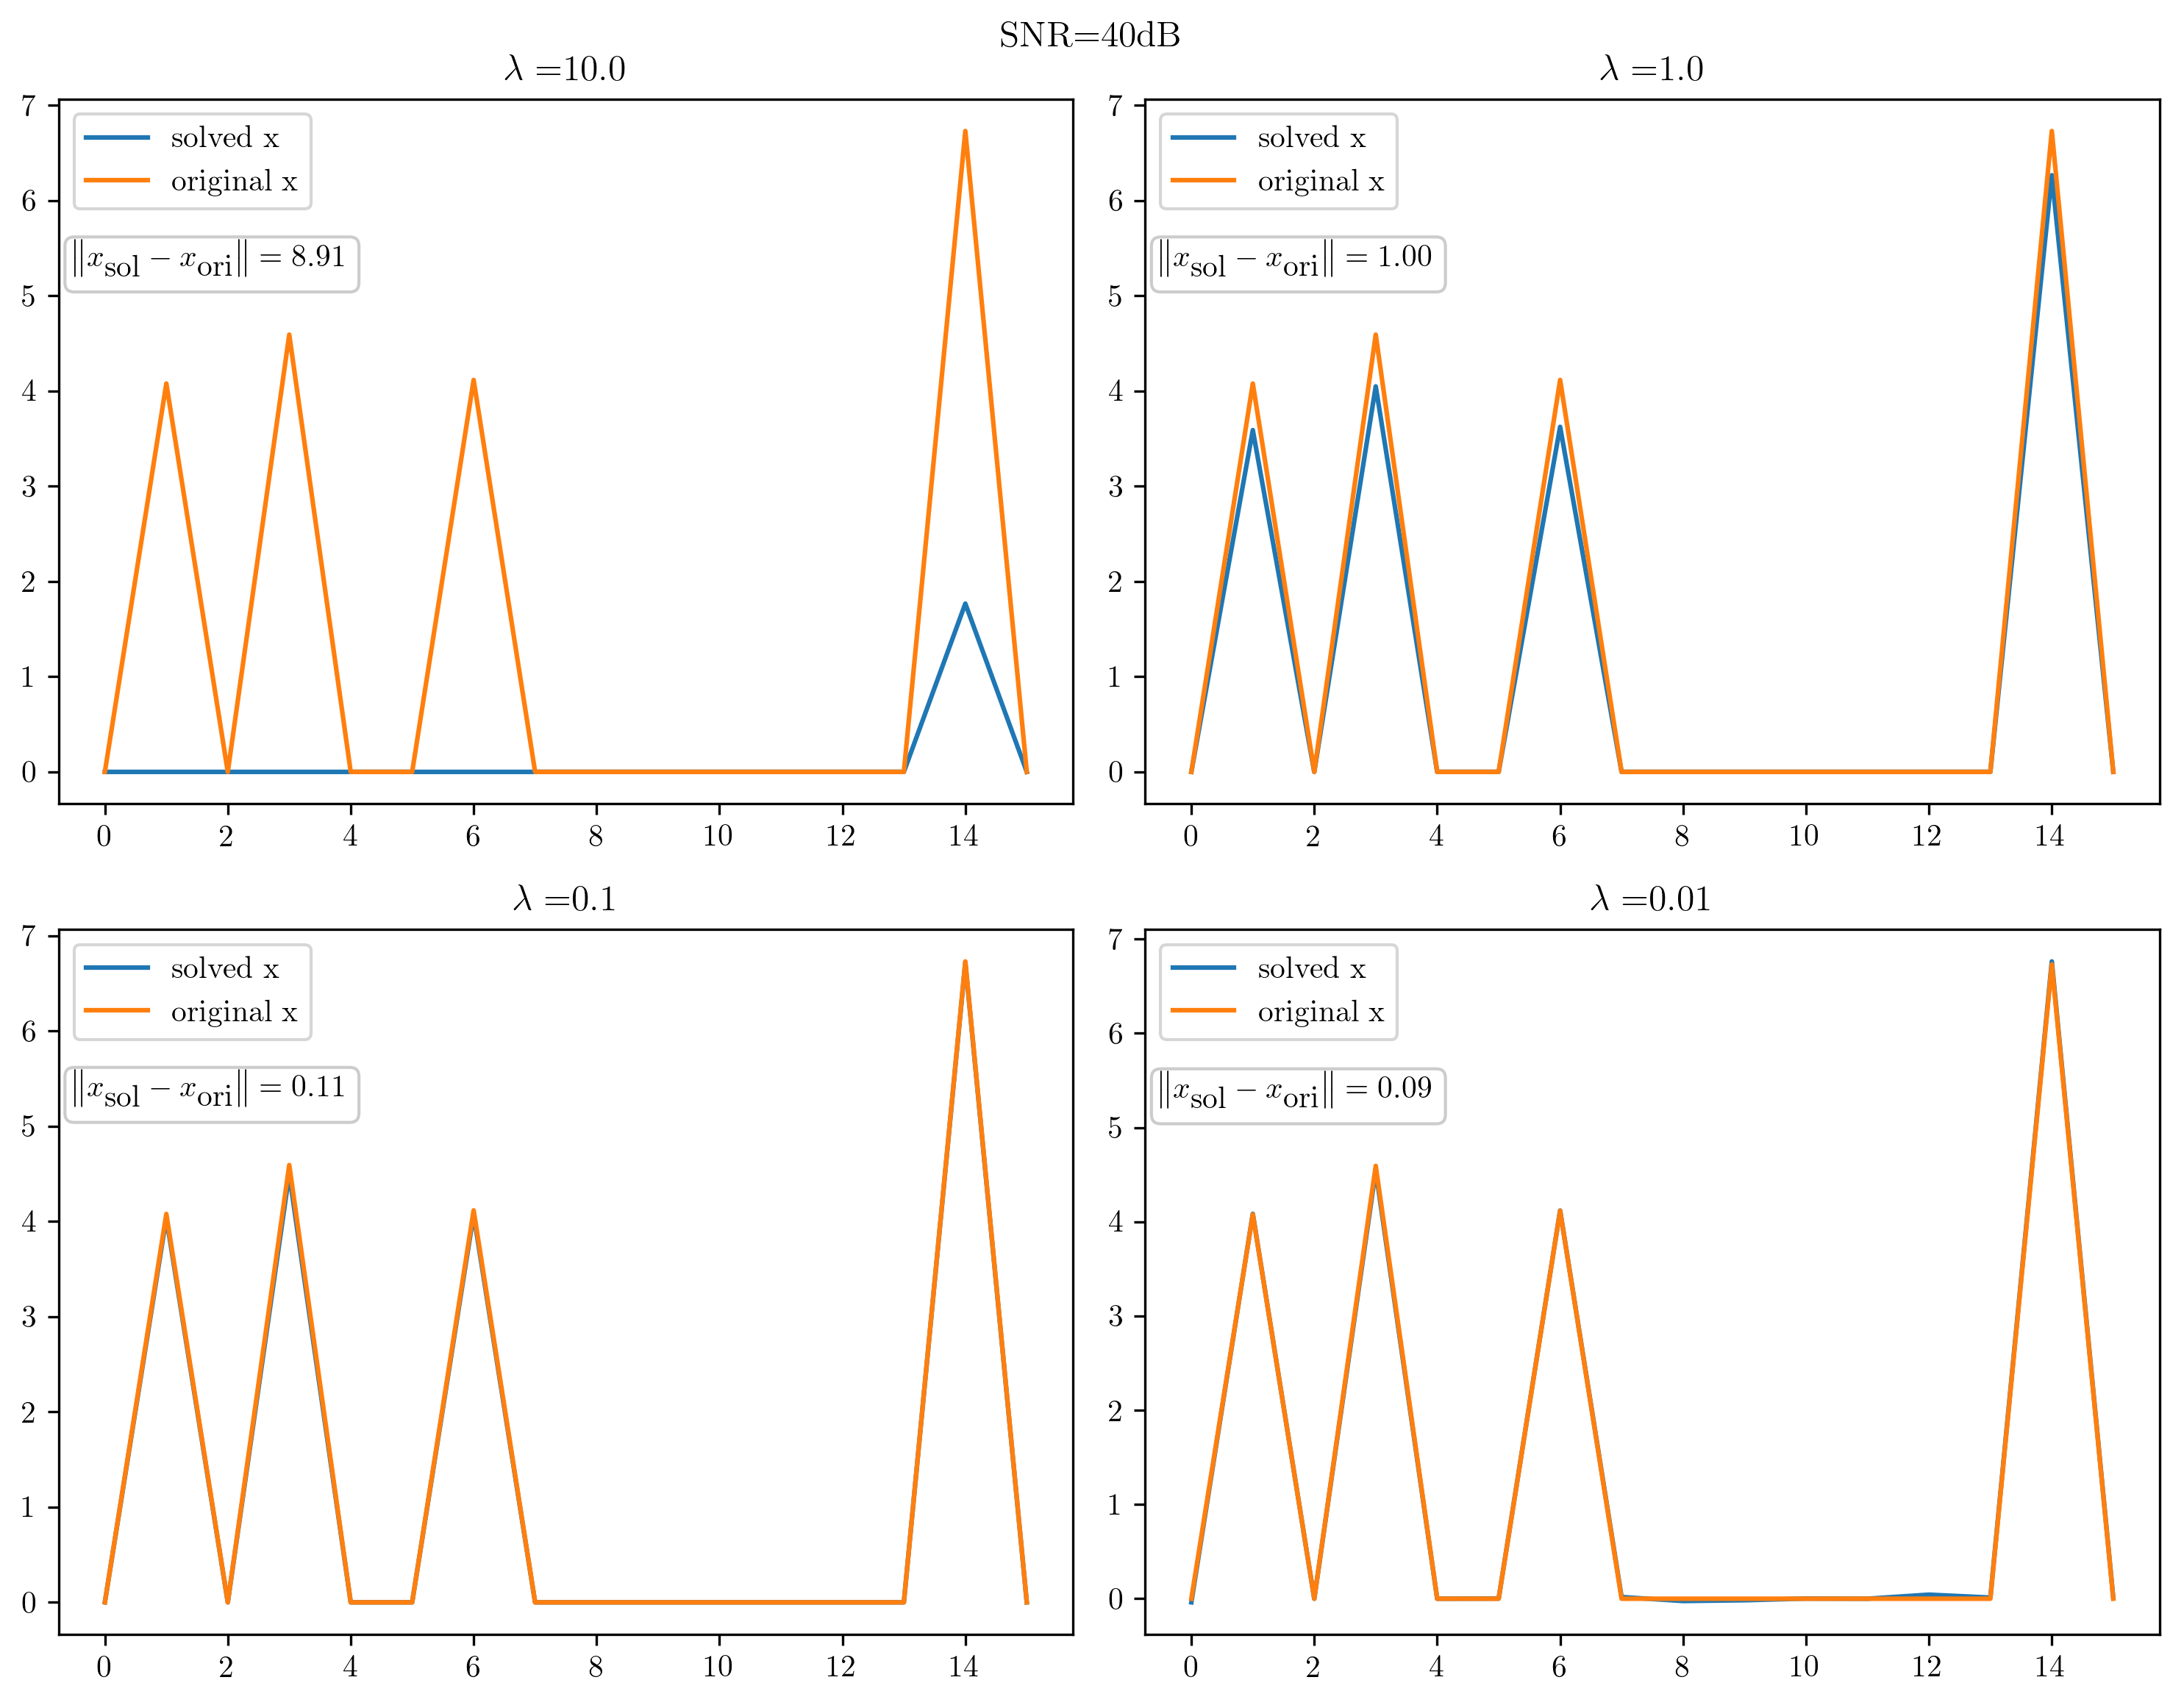

In [11]:
k = 3
y = Y[k]
x_std = X[k]
SNR_i = range(10,101,10)[k]
plt.figure(dpi=300,figsize=(10,8))
plt.suptitle("SNR="+str(SNR_i)+"dB")
for Id, il in enumerate(Lambda):
    plt.subplot(221+Id)
    x_re,_,_ = ISTA(y, H_16, lamb=il)
    plt.plot(range(16),x_re,label='solved x')
    plt.plot(range(16),x_std,label='original x')
    plt.text(-0.5,5.2,"$\\left\|{x}_{\\textup{sol}}-{x}_{\\textup{ori}}\\right\|="+'%.2f'%LA.norm(x_re-x_std,2)+"$",
             bbox=dict(boxstyle="round",
                   ec=(0.8, 0.8, 0.8),
                   fc=(1, 1, 1)))
    plt.title("$\lambda=$"+str(il))
    plt.legend(loc = 'upper left')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])

We conclude the following statements from all plots above:

* ISTA algorithm gives a sparse solution.

* As the regularization factor goes larger, more and more coefficients in DCT are prone to be zeros. For this experiment, lambda = 10 is strong enough to force most of them to be zeros.

* For noisy signals with different SNR, the best regularization factor differs. We use the norm of the difference of "pure" signal and noisy signal to evaluate the effect of denoising. The plots show that lambda = 1 is the best for SNR = `10dB`, 0.1 for `20,30dB` and 0.01 for `40dB`. It's very intuitive that a high regularization factor tends to make a signal with high SNR lose more effective energy.

* For a signal with low SNR, ISTA still hardly give a "perfect" recovery.

# 3. Wavelets and ISTA

Read the "Lenna" image.

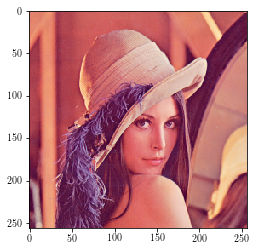

In [12]:
img = cv2.imread('C:/Users/ZING/Desktop/6123/CA/Sol/CA3/Lenna.jpg')
plt.imshow(img[:,:,[2,1,0]])

Implement enoise function for a digital image using given SNR. SNR for a digital image is given by:

$$\text{SNR}=10{{\log }_{10}}\left( \frac{{{P}_{s}}}{{{P}_{n}}} \right)=10{{\log }_{10}}\left( \frac{\sum\limits_{m,n}{S\left( m,n \right)}}{\sum\limits_{m,n}{N\left( m,n \right)}} \right)$$

Note that instead of the whole image, SNR is calculate for each color channel respectively. 

In [13]:
def imnoise(img,snr):
    '''
    add Gaussian nosie with given SNR onto given img.
    input:
    img: a image in grayscale or in colorfulscale(RGB/BGR)
    snr: signal noise ratios in dB
    return:
    nimg: nosied image
    '''
    if img.ndim == 3:
        nimg = img.astype('float')
        shape = img[:,:,0].shape
        for i in range(3):
            Pn = (np.sum(img[:,:,i].astype('float') ** 2) / 3) / 10 ** (snr / 10)
            n = np.random.normal(0,1,shape)
            nimg[:,:,i] = nimg[:,:,i] + n * np.sqrt(Pn / np.sum(n ** 2))
    else: 
        nimg = img.astype('float')
        shape = img.shape
        Pn = (np.sum(img.astype('float') ** 2)) / 10 ** (snr / 10)
        n = np.random.normal(0,1,shape)
        nimg = nimg + n * np.sqrt(Pn / np.sum(n ** 2))
        
    nimg[np.where(nimg > 255)] = 255
    nimg[np.where(nimg < 0)] = 0
    
    return nimg.astype('uint8')

Enoise the image.

([], <a list of 0 Text yticklabel objects>)

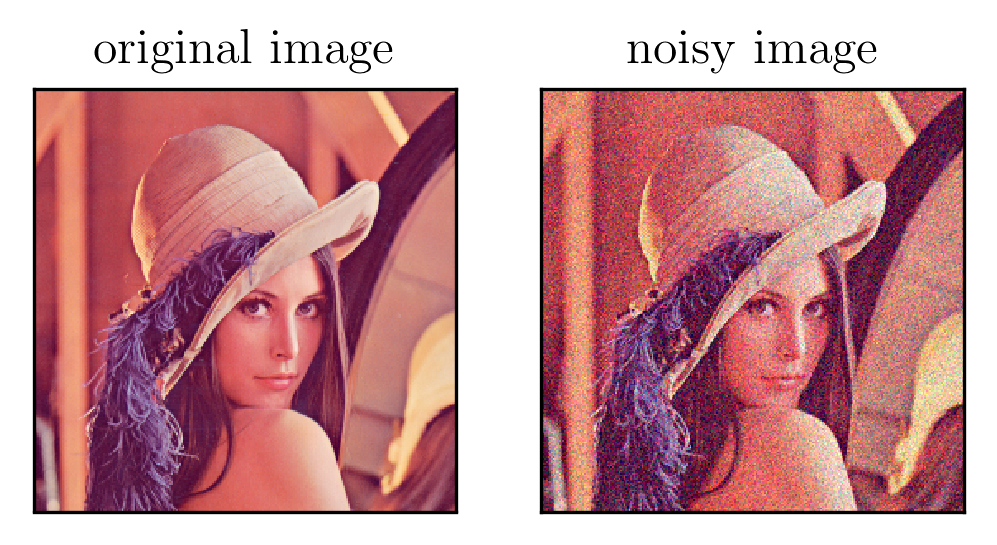

In [14]:
nimg = imnoise(img,10)
plt.figure(dpi = 300, figsize = [4,2])
plt.subplot(121)
plt.title('original image')
plt.imshow(img[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.title('noisy image')
plt.imshow(nimg[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

Implement function `coef2img` for ensembling wavelet coefficents to a coefficients image so it can be shown.

In [15]:
def coef2img(coef,rec=0):
    '''
    return uint8 RGB ranged in (0,255)
    '''
    if np.shape(coef[0]) != np.shape(coef[1]): # grayscale
        level = np.shape(coef)[0] - 1
        img = coef[0]
        for i in range(1, level+1):
            [m1,n1] = np.shape(img)
            [m2,n2] = np.shape(coef[i][0])
            img = np.hstack((img,np.pad(coef[i][0],((0,m1-m2),(0,0)),
                                              'constant', constant_values=((0,0), (0,0)))))
            img = np.vstack((img,np.hstack((np.pad(coef[i][1],((0,0),(0,n1-n2)),
                                              'constant', constant_values=((0,0), (0,0))),
                                                  np.pad(coef[i][2],((0,0),(0,0)),
                                              'constant', constant_values=((0,0), (0,0)))))))
    else: # colorscale
        nchannel = np.shape(coef)[0]
        level = np.shape(coef[0])[0] - 1
        img = []
        for ic in range(nchannel):
            img.append(coef2img(coef[ic],1))
    
        img = np.array(img)
        img = np.swapaxes(img,0,1)
        img = np.swapaxes(img,1,2)
    if rec == 0:
        imgmin = np.min(img)
        imgmax = np.max(img)
        img = np.round((img - imgmin) / (imgmax - imgmin + 1e-8) * 255)
        return img.astype('uint8')
    return img


Implement `forward_transform` and `inverse_transform` functions with give wavelet kernel. 

Note that they automatically handle colorful images or grayscaled images.

In [16]:
def forward_transform(img, wavelet, level):
    if img.ndim == 3:
        coeffs = []
        for i in range(3):
            coeffs.append(pywt.wavedec2(img[:,:,i], wavelet = wavelet, level = level))
    else:
        coeffs = pywt.wavedec2(img, wavelet = wavelet, level = level)
    
    return coeffs

In [17]:
def inverse_transform(coef, wavelet):
    if np.shape(coef[0]) != np.shape(coef[1]): # grayscale
        return pywt.waverec2(coef, wavelet = wavelet)
    else:
        nchannel = np.shape(coef)[0]
        img = []
        for ic in range(nchannel):
            img.append(pywt.waverec2(coef[ic], wavelet = wavelet))
        img = np.array(img)
        img = np.swapaxes(img,0,1)
        img = np.swapaxes(img,1,2)
        return img

Text(0.5,1,'Wavelet Decomposition on Lenna, level=3, haar')

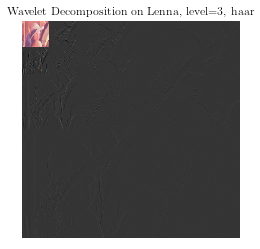

In [25]:
coeffs = forward_transform(img,'haar',3)
wimg = coef2img(forward_transform(img,'haar',3))
plt.imshow(wimg[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title("Wavelet Decomposition on Lenna, level=3, haar")

For the purpose of a proper data structure for later ISTA algorithm, implement `coef2array` and `array2coef` functions. 

`coef2array` flattens a `list` of wavelet coefficients into an `numpy.array` and `array2coef` reverses this operation.

In [23]:
def coef2array(X):
    if np.shape(X[0]) != np.shape(X[1]): #grayscale
        x = X[0].flatten()
        level = np.shape(X)[0]
        for i in range(1,level):
            for j in range(3):
                x = np.hstack((x,X[i][j].flatten()))
    else: # grayscale
        x = np.array([])
        for i in range(np.shape(X)[0]):
            x = np.hstack((x,coef2array(X[i])))
    return x

def array2coef(x,temp,point = 0):
    if np.shape(temp[0]) != np.shape(temp[1]): # grayscale:
        m, n = np.shape(temp[0])
        X = [x[point:point + m * n].reshape([m,n])]
        point += m * n
        level = np.shape(temp)[0]
        for i in range(1,level):
            xt = []
            _, m, n = np.shape(temp[i])
            for j in range(3):
                xt.append(x[point:point + m * n].reshape([m,n]))
                point += m * n
            X.append(tuple(xt))
    else:
        X = []
        for i in range(np.shape(temp)[0]):
            xt, point = array2coef(x,temp[i],point)
            X.append(xt)
    
    return X, point

Verify `coef2array` and `array2coef`

In [26]:
x = coef2array(coeffs)
rec_coeffs,_ = array2coef(x,coeffs)
print(np.all(coeffs[1][2][2] == rec_coeffs[1][2][2]))

True


Implement ISTA algorithm for wavelet-decomposition-based denoising

In [27]:
def initialX(temp, mean, std):
    if np.shape(temp[0]) != np.shape(temp[1]): # grayscale
        X = [np.random.normal(mean,std,np.shape(temp[0]))]
        level = np.shape(temp)[0]
        for i in range(1,level):
            x = []
            x.append(np.zeros(np.shape(temp[i][0])))
            x.append(np.zeros(np.shape(temp[i][0])))
            x.append(np.zeros(np.shape(temp[i][0])))
            X.append(x)
        return X
    else:
        X = []
        X.append(initialX(temp[0], mean, std))
        X.append(initialX(temp[0], mean, std))
        X.append(initialX(temp[0], mean, std))
    return X

def soft_filter(Y, wavelet, X, level, T):
    # return an array
    if np.shape(X[0]) != np.shape(X[1]): # grayscale
        x = np.array([])
        LL = Y - inverse_transform(X, wavelet)
        #coef = forward_transform(LL, wavelet, 1)
        for i in range(level):
            coef = forward_transform(LL, wavelet, 1)
            LL = coef[0]
            nLL = np.hstack((coef[1][0].flatten(),np.hstack((coef[1][1].flatten(),coef[1][2].flatten()))))
            x = np.hstack((soft(nLL, T), x)) # soft filtering
        x = np.hstack((soft(LL.flatten(), T), x))
        return x
    else:
        x = np.array([])
        for i in range(3):
            x = np.hstack((x, soft_filter(Y[:,:,i], wavelet, X[i], level, T)))
        return x


def J_w(Y, wavelet, X, level, lamb):
    return np.sqrt(np.sum((Y - inverse_transform(X, wavelet)) ** 2)) + lamb * np.sum(np.abs(coef2array(X)))
    
    
def ISTA_w(Y, wavelet, lamb, level, err=1e-7, steps=1e3):
    '''
    solve such a LASSO problem:
        min with parameter x: J(x) = norm(Y - inv(x), 2) ^ 2 + lamb * norm(x, 1)
    where:
        Y: image with shape of (m,n) or (m,n,c)
        wavelet: wavelet transform kernel
        x: wavelet coeffs with the same shape of Y
        lamb: LASSO regularization
    
    Iteration format is defined as:
    x' = soft(x + 1 / alpha * forward(y - inv(x)), lamb / alpha / 2)
    
    return:
    x: optimum vector x
    J: optimum cost J
    Itr: # iterations
    '''
    shape = Y.shape
    mean = np.mean(Y)
    try:
        std = np.std(np.sum(Y,2) / 3)
    except:
        stf = np.std(Y)
    mnc = np.round(np.exp(np.sum(np.log(shape)))).astype('int32')
    X_template = forward_transform(Y,wavelet,level)
    zero_template = forward_transform(np.zeros(np.shape(Y)),wavelet,level)
    
    X_opt = initialX(X_template, 0, std)

    J_opt = J_w(Y, wavelet, X_opt, level, lamb)
    '''
    for _ in range(10):
        x1 = np.random.rand(n)
        J1 = J(y, H, x1, lamb)
        if J_opt > J1:
            x_opt = x1
            J_opt = J1
    '''
    
    # initialize iteration
    Itr = 0
    alpha = 1.01
    
    J0 = J_opt
    J1 = J0 * err * 10
    X0 = X_opt
    X1 = X_opt
    J_hist = []
    # iterating
    #'''
    while (np.abs((J0 - J1) / J0) >= err) & (Itr < steps):
        X0 = X1
        J0 = J1

        X1,_ = array2coef(coef2array(X0) + 1 / alpha * coef2array(forward_transform(Y - inverse_transform(X0,wavelet), wavelet, level)),
                         X_template)
        X1,_ = array2coef(soft_filter(inverse_transform(X1,wavelet), wavelet, zero_template, level, lamb / alpha / 2),
                         X_template)
        
        J1 = J_w(Y, wavelet, X1, level, lamb)
        
        J_hist.append(J1)
        Itr += 1
    #'''
    #X1,_ = array2coef(soft_filter(Y.astype('float'), wavelet, X0, level, lamb / alpha / 2),X_template)
    return X1, J_hist, Itr

In [28]:
'''
wl_kernel = 'db8'
level = 3
deimg_coef,J_hist,_ = ISTA_w(nimg, wl_kernel, lamb = 1e1, level = level, err=1e-7, steps=20)
'''

"\nwl_kernel = 'db8'\nlevel = 3\ndeimg_coef,J_hist,_ = ISTA_w(nimg, wl_kernel, lamb = 1e1, level = level, err=1e-7, steps=20)\n"

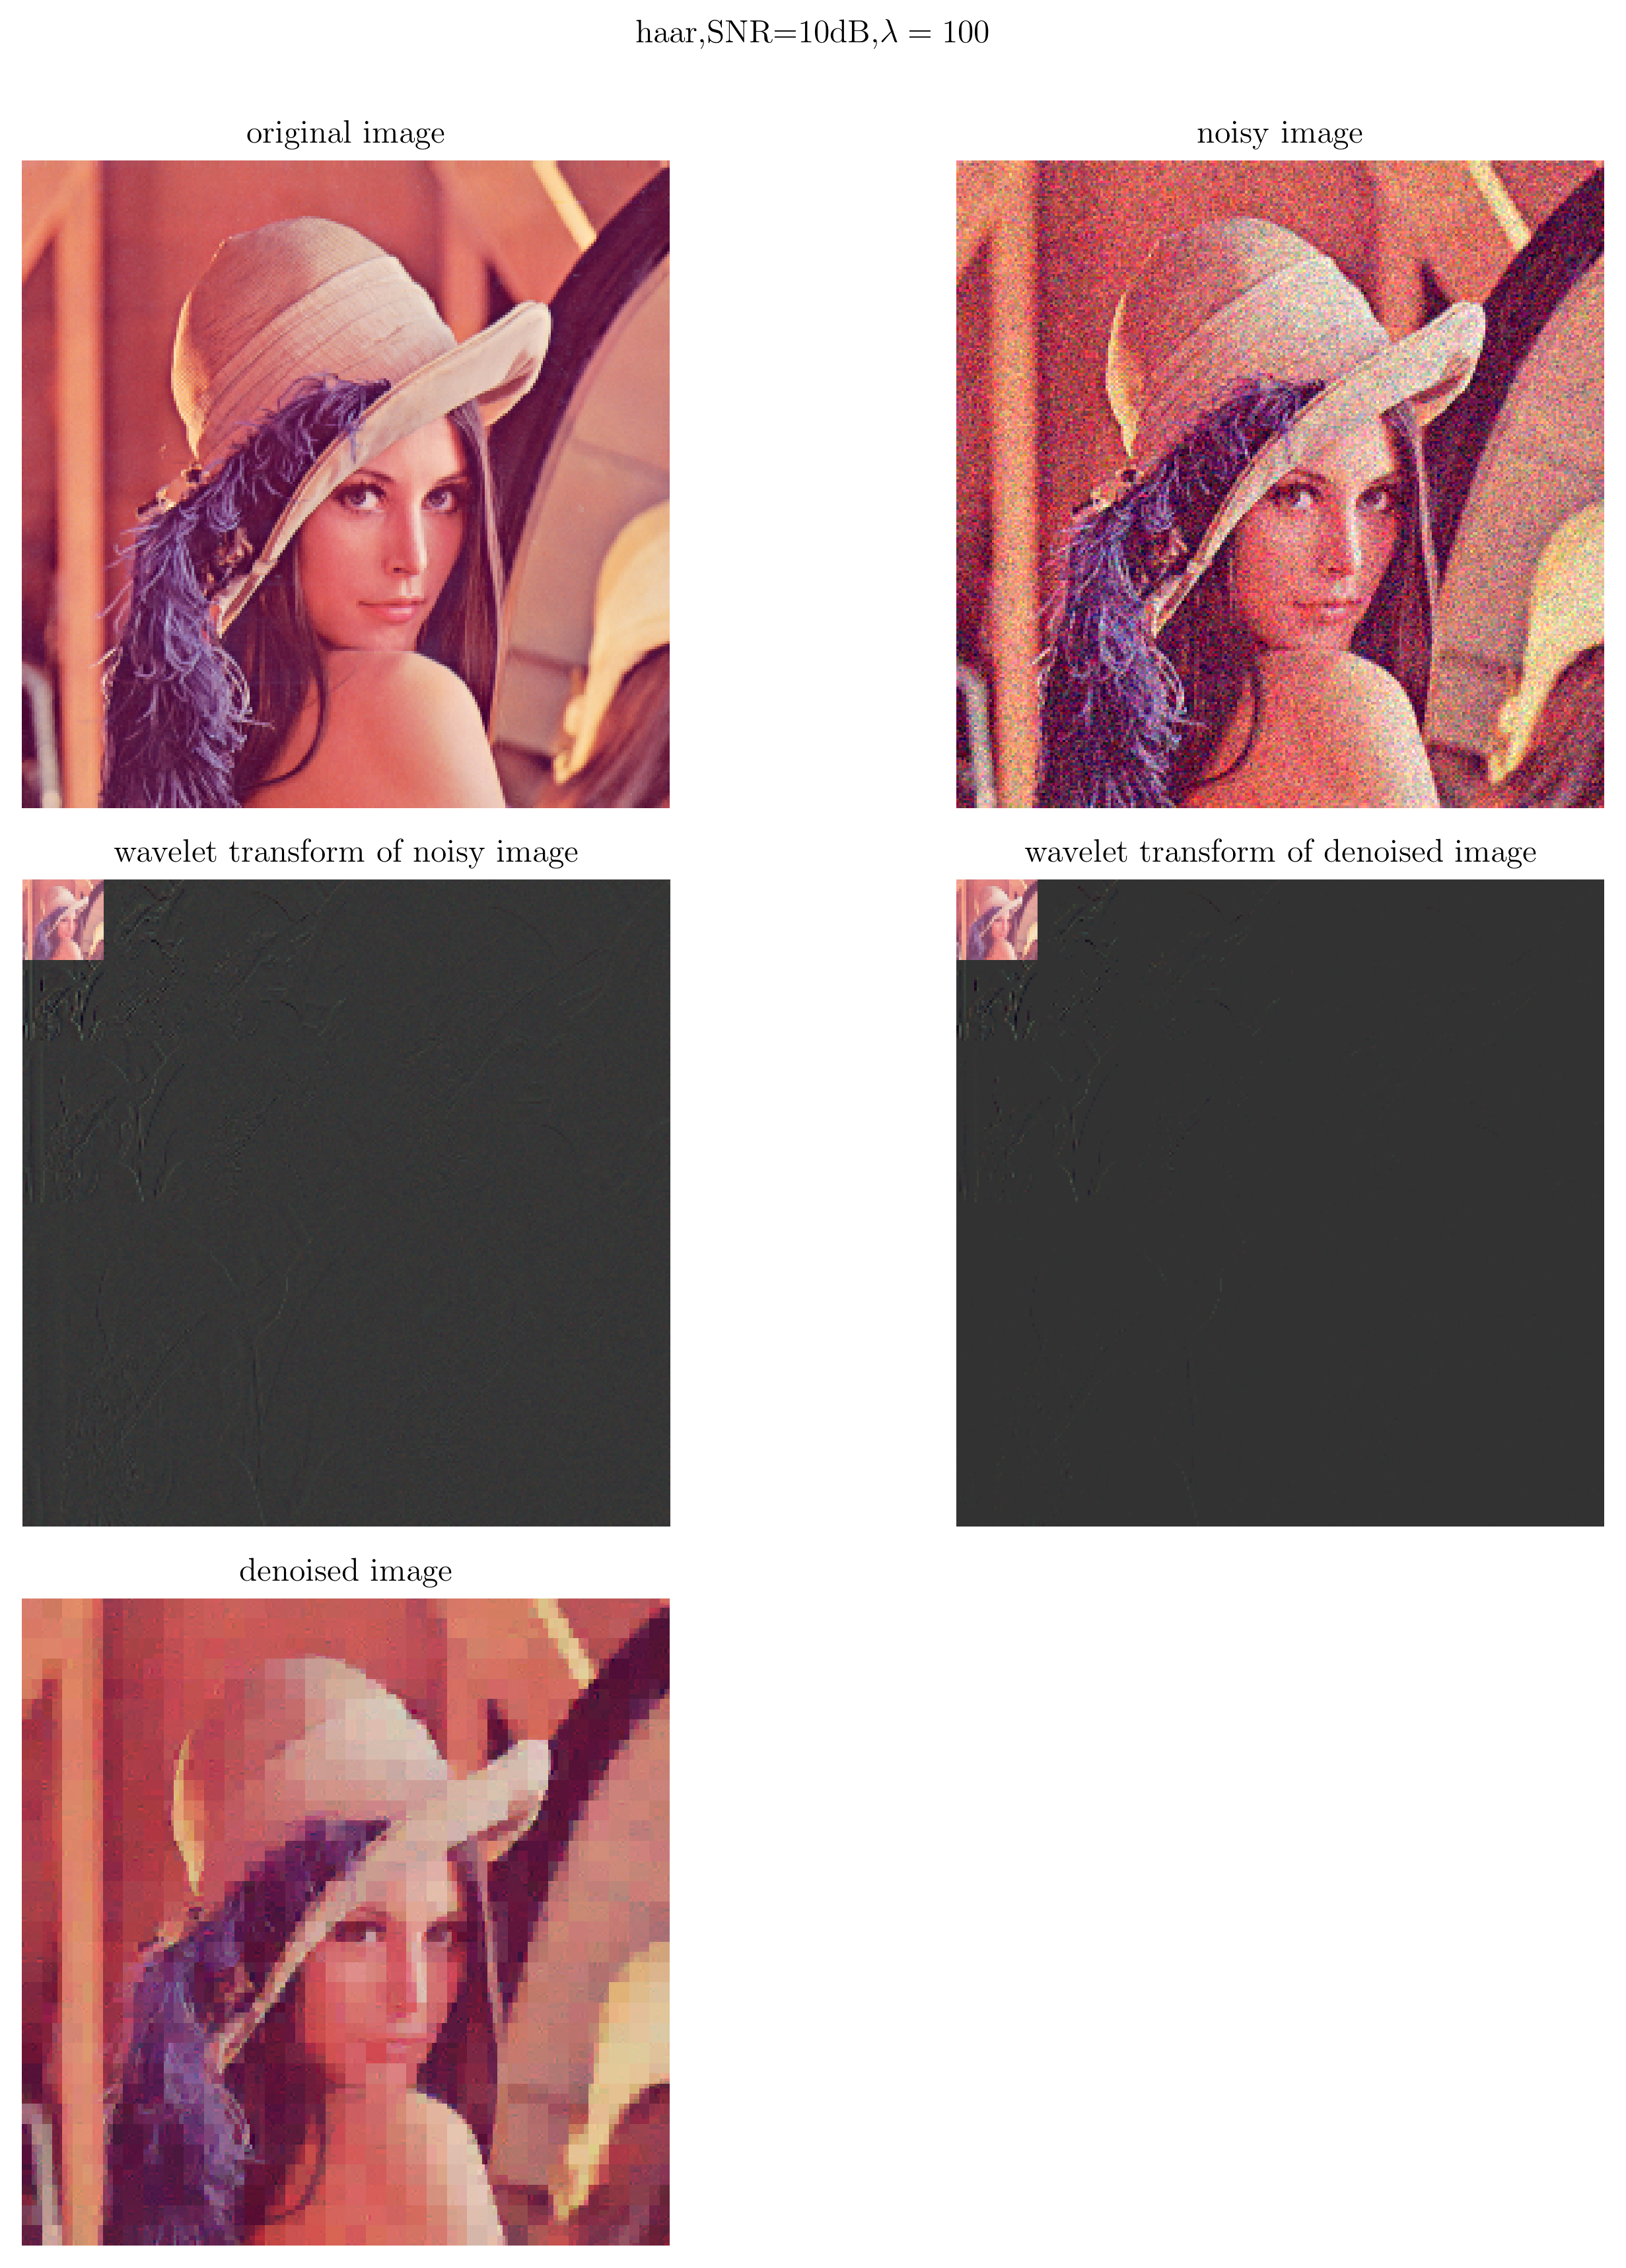

In [29]:
# Haar, level = 3, SNR = 10dB, lambda 
wl_kernel = 'haar'
level = 3

plt.figure(dpi = 300, figsize = [10,12])
plt.suptitle('haar,SNR=10dB,$\lambda=100$')
plt.subplot(321)
plt.imshow(img[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('original image')
plt.subplot(322)
plt.imshow(nimg[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('noisy image')

nimg_coef = forward_transform(nimg,wl_kernel,level)
plt.subplot(323)
plt.imshow(coef2img(nimg_coef)[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of noisy image')

deimg_coef,J_hist,_ = ISTA_w(nimg, wl_kernel, lamb = 100, level = level, err=1e-9, steps=1e2)
plt.subplot(324)
plt.imshow(coef2img(deimg_coef).astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of denoised image')

plt.subplot(325)
denimg = inverse_transform(deimg_coef,wl_kernel)
denimg[np.where(denimg > 255)] = 255
denimg[np.where(denimg < 0)] = 0
plt.imshow(denimg.astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('denoised image')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

wavelet kernel `haar` will introduce severe blocky effect after denosing, though the sharp noise has been removed.

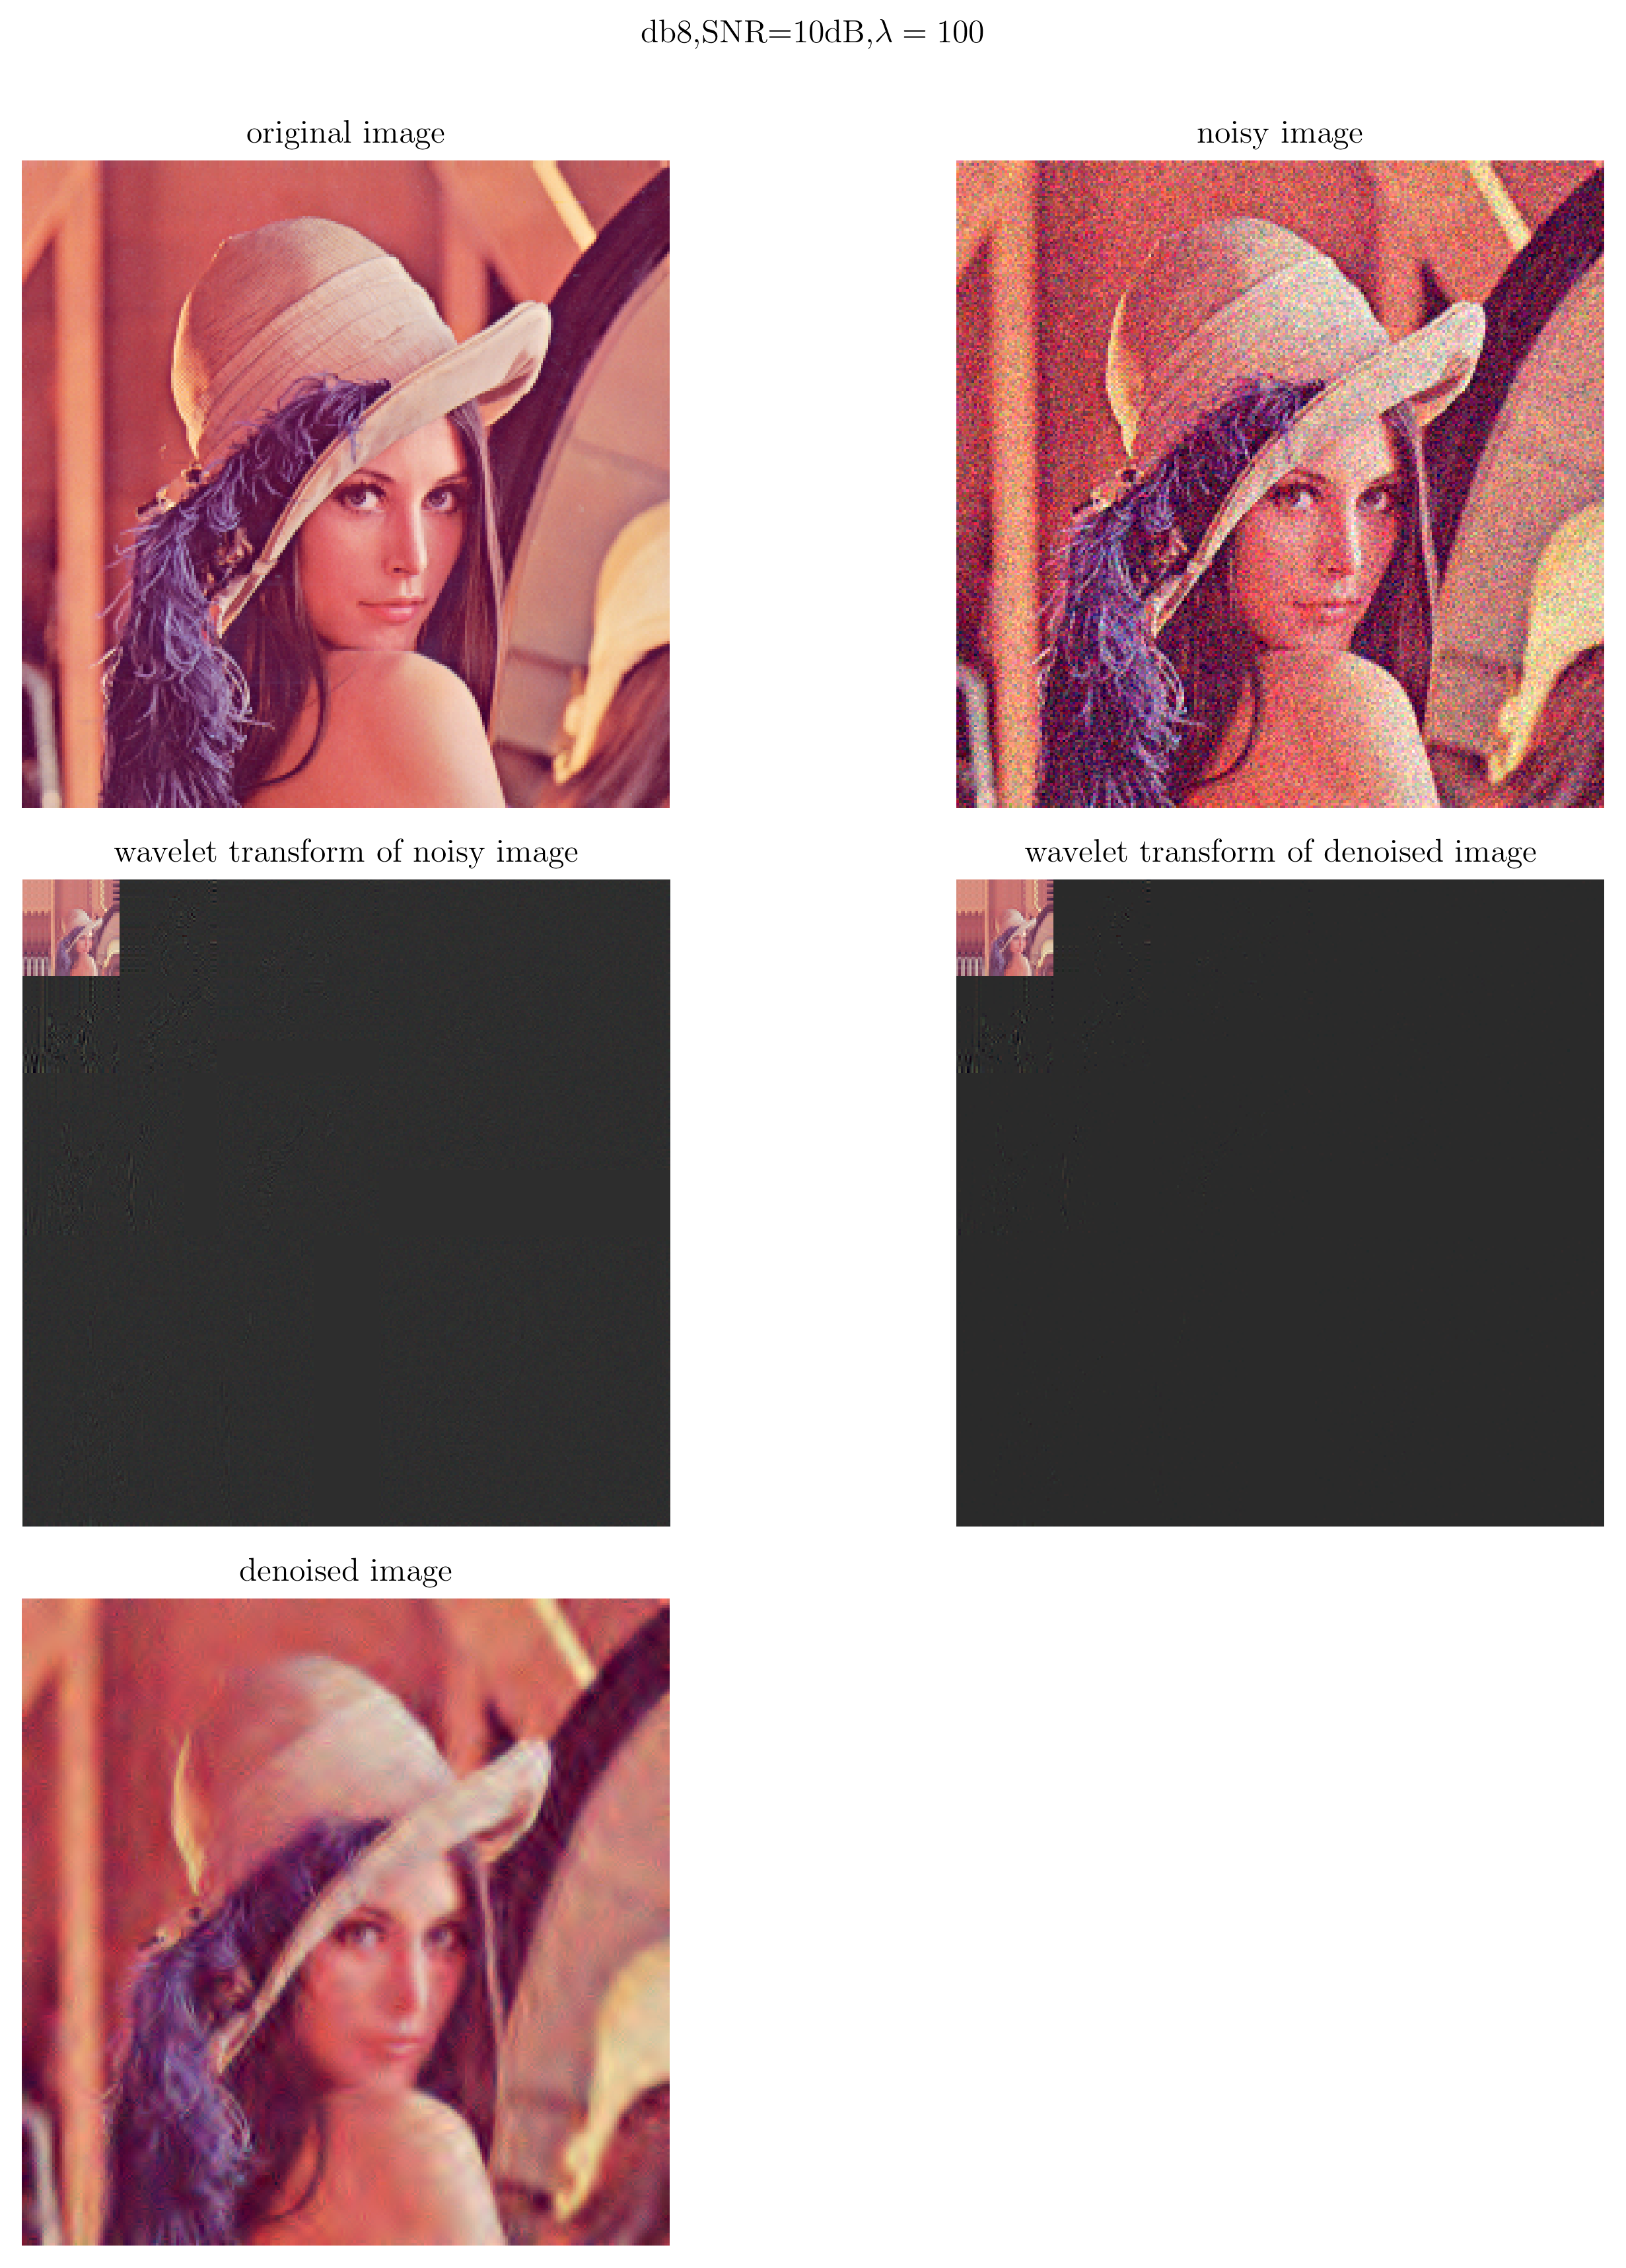

In [30]:
wl_kernel = 'db8'
level = 3

plt.figure(dpi = 300, figsize = [10,12])
plt.suptitle('db8,SNR=10dB,$\lambda=100$')
plt.subplot(321)
plt.imshow(img[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('original image')
plt.subplot(322)
plt.imshow(nimg[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('noisy image')

nimg_coef = forward_transform(nimg,wl_kernel,level)
plt.subplot(323)
plt.imshow(coef2img(nimg_coef)[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of noisy image')

deimg_coef,J_hist,_ = ISTA_w(nimg, wl_kernel, lamb = 100, level = level, err=1e-9, steps=1e2)
plt.subplot(324)
plt.imshow(coef2img(deimg_coef).astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of denoised image')

plt.subplot(325)
denimg = inverse_transform(deimg_coef,wl_kernel)
denimg[np.where(denimg > 255)] = 255
denimg[np.where(denimg < 0)] = 0
plt.imshow(denimg.astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('denoised image')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

With other arguments fixed, `db8` kernel achieved the same effect in removing noise, however it introduced a severe blurring.

Run denoising on the image with `SNR=20dB`. Adjust arguments properly.

In [31]:
nimg_20 = imnoise(img,20)

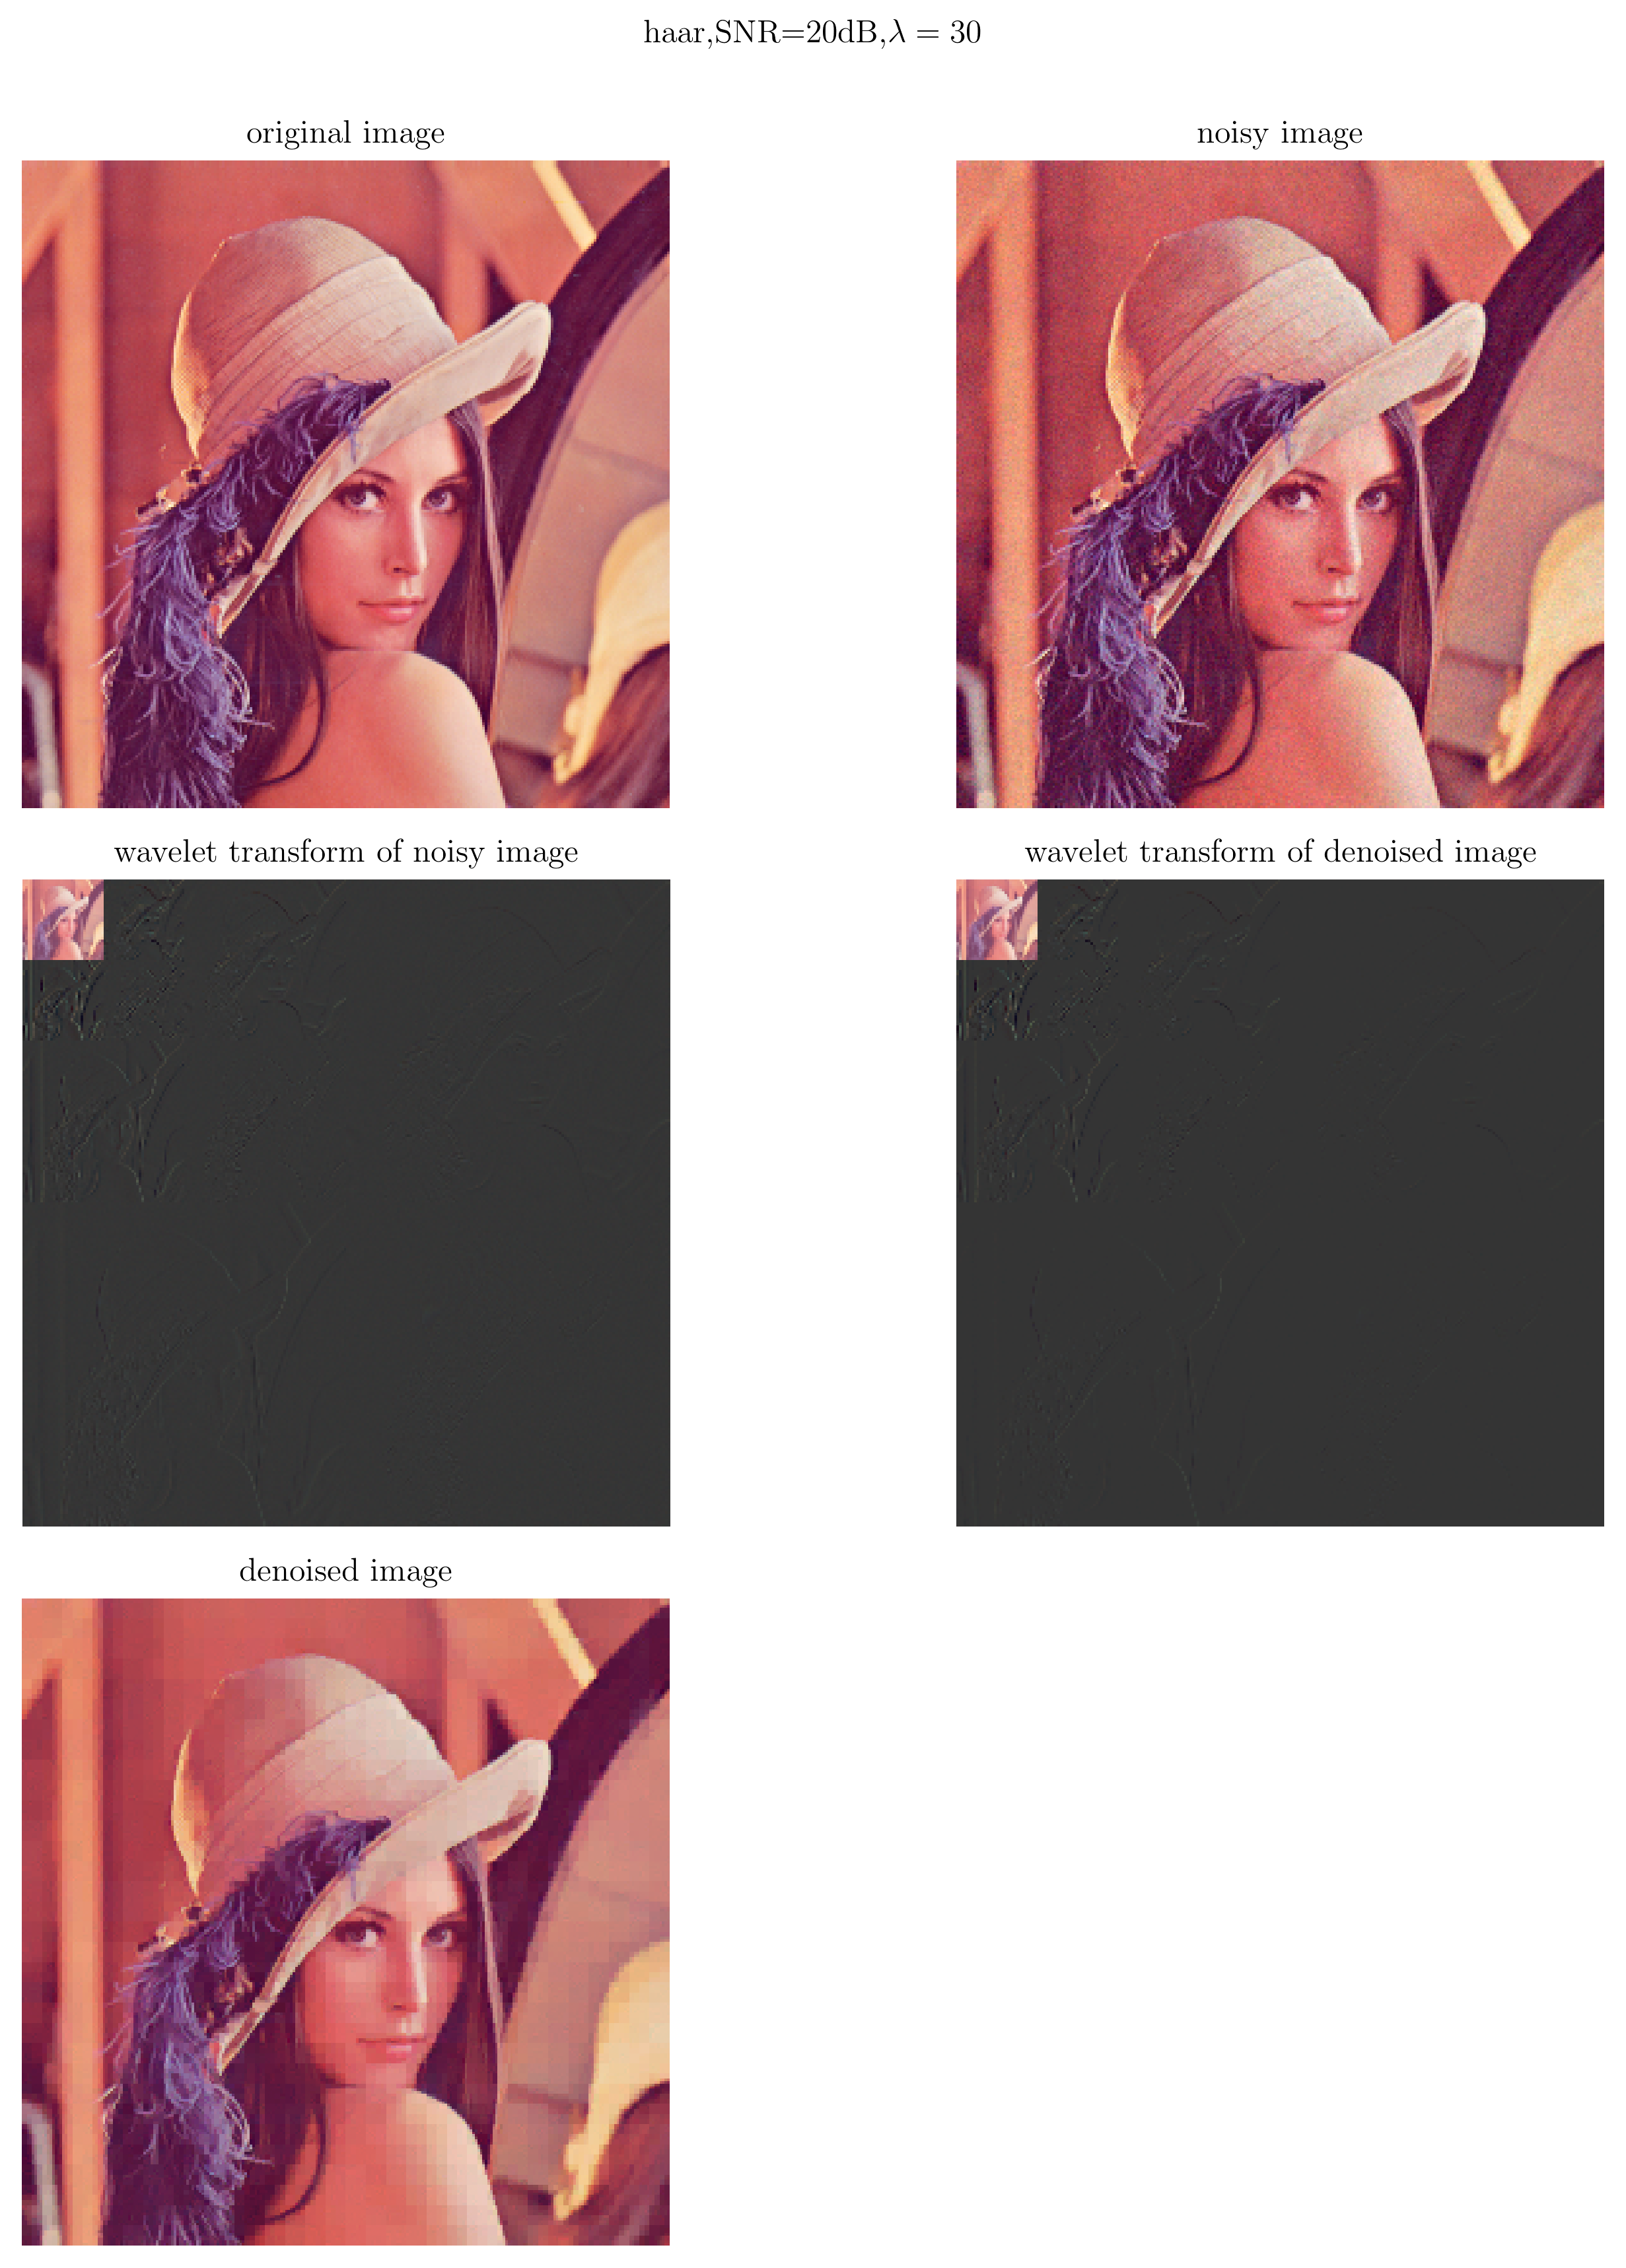

In [32]:
# Haar, level = 3, SNR = 10dB, lambda 
wl_kernel = 'haar'
level = 3

plt.figure(dpi = 300, figsize = [10,12])
plt.suptitle('haar,SNR=20dB,$\lambda=30$')
plt.subplot(321)
plt.imshow(img[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('original image')
plt.subplot(322)
plt.imshow(nimg_20[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('noisy image')

nimg_coef = forward_transform(nimg_20,wl_kernel,level)
plt.subplot(323)
plt.imshow(coef2img(nimg_coef)[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of noisy image')

deimg_coef,J_hist,_ = ISTA_w(nimg_20, wl_kernel, lamb = 30, level = level, err=1e-9, steps=1e2)
plt.subplot(324)
plt.imshow(coef2img(deimg_coef).astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of denoised image')

plt.subplot(325)
denimg = inverse_transform(deimg_coef,wl_kernel)
denimg[np.where(denimg > 255)] = 255
denimg[np.where(denimg < 0)] = 0
plt.imshow(denimg.astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('denoised image')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

With `lambda=30`, `haar` achieved a good denoising though still brought about much blocky effect.

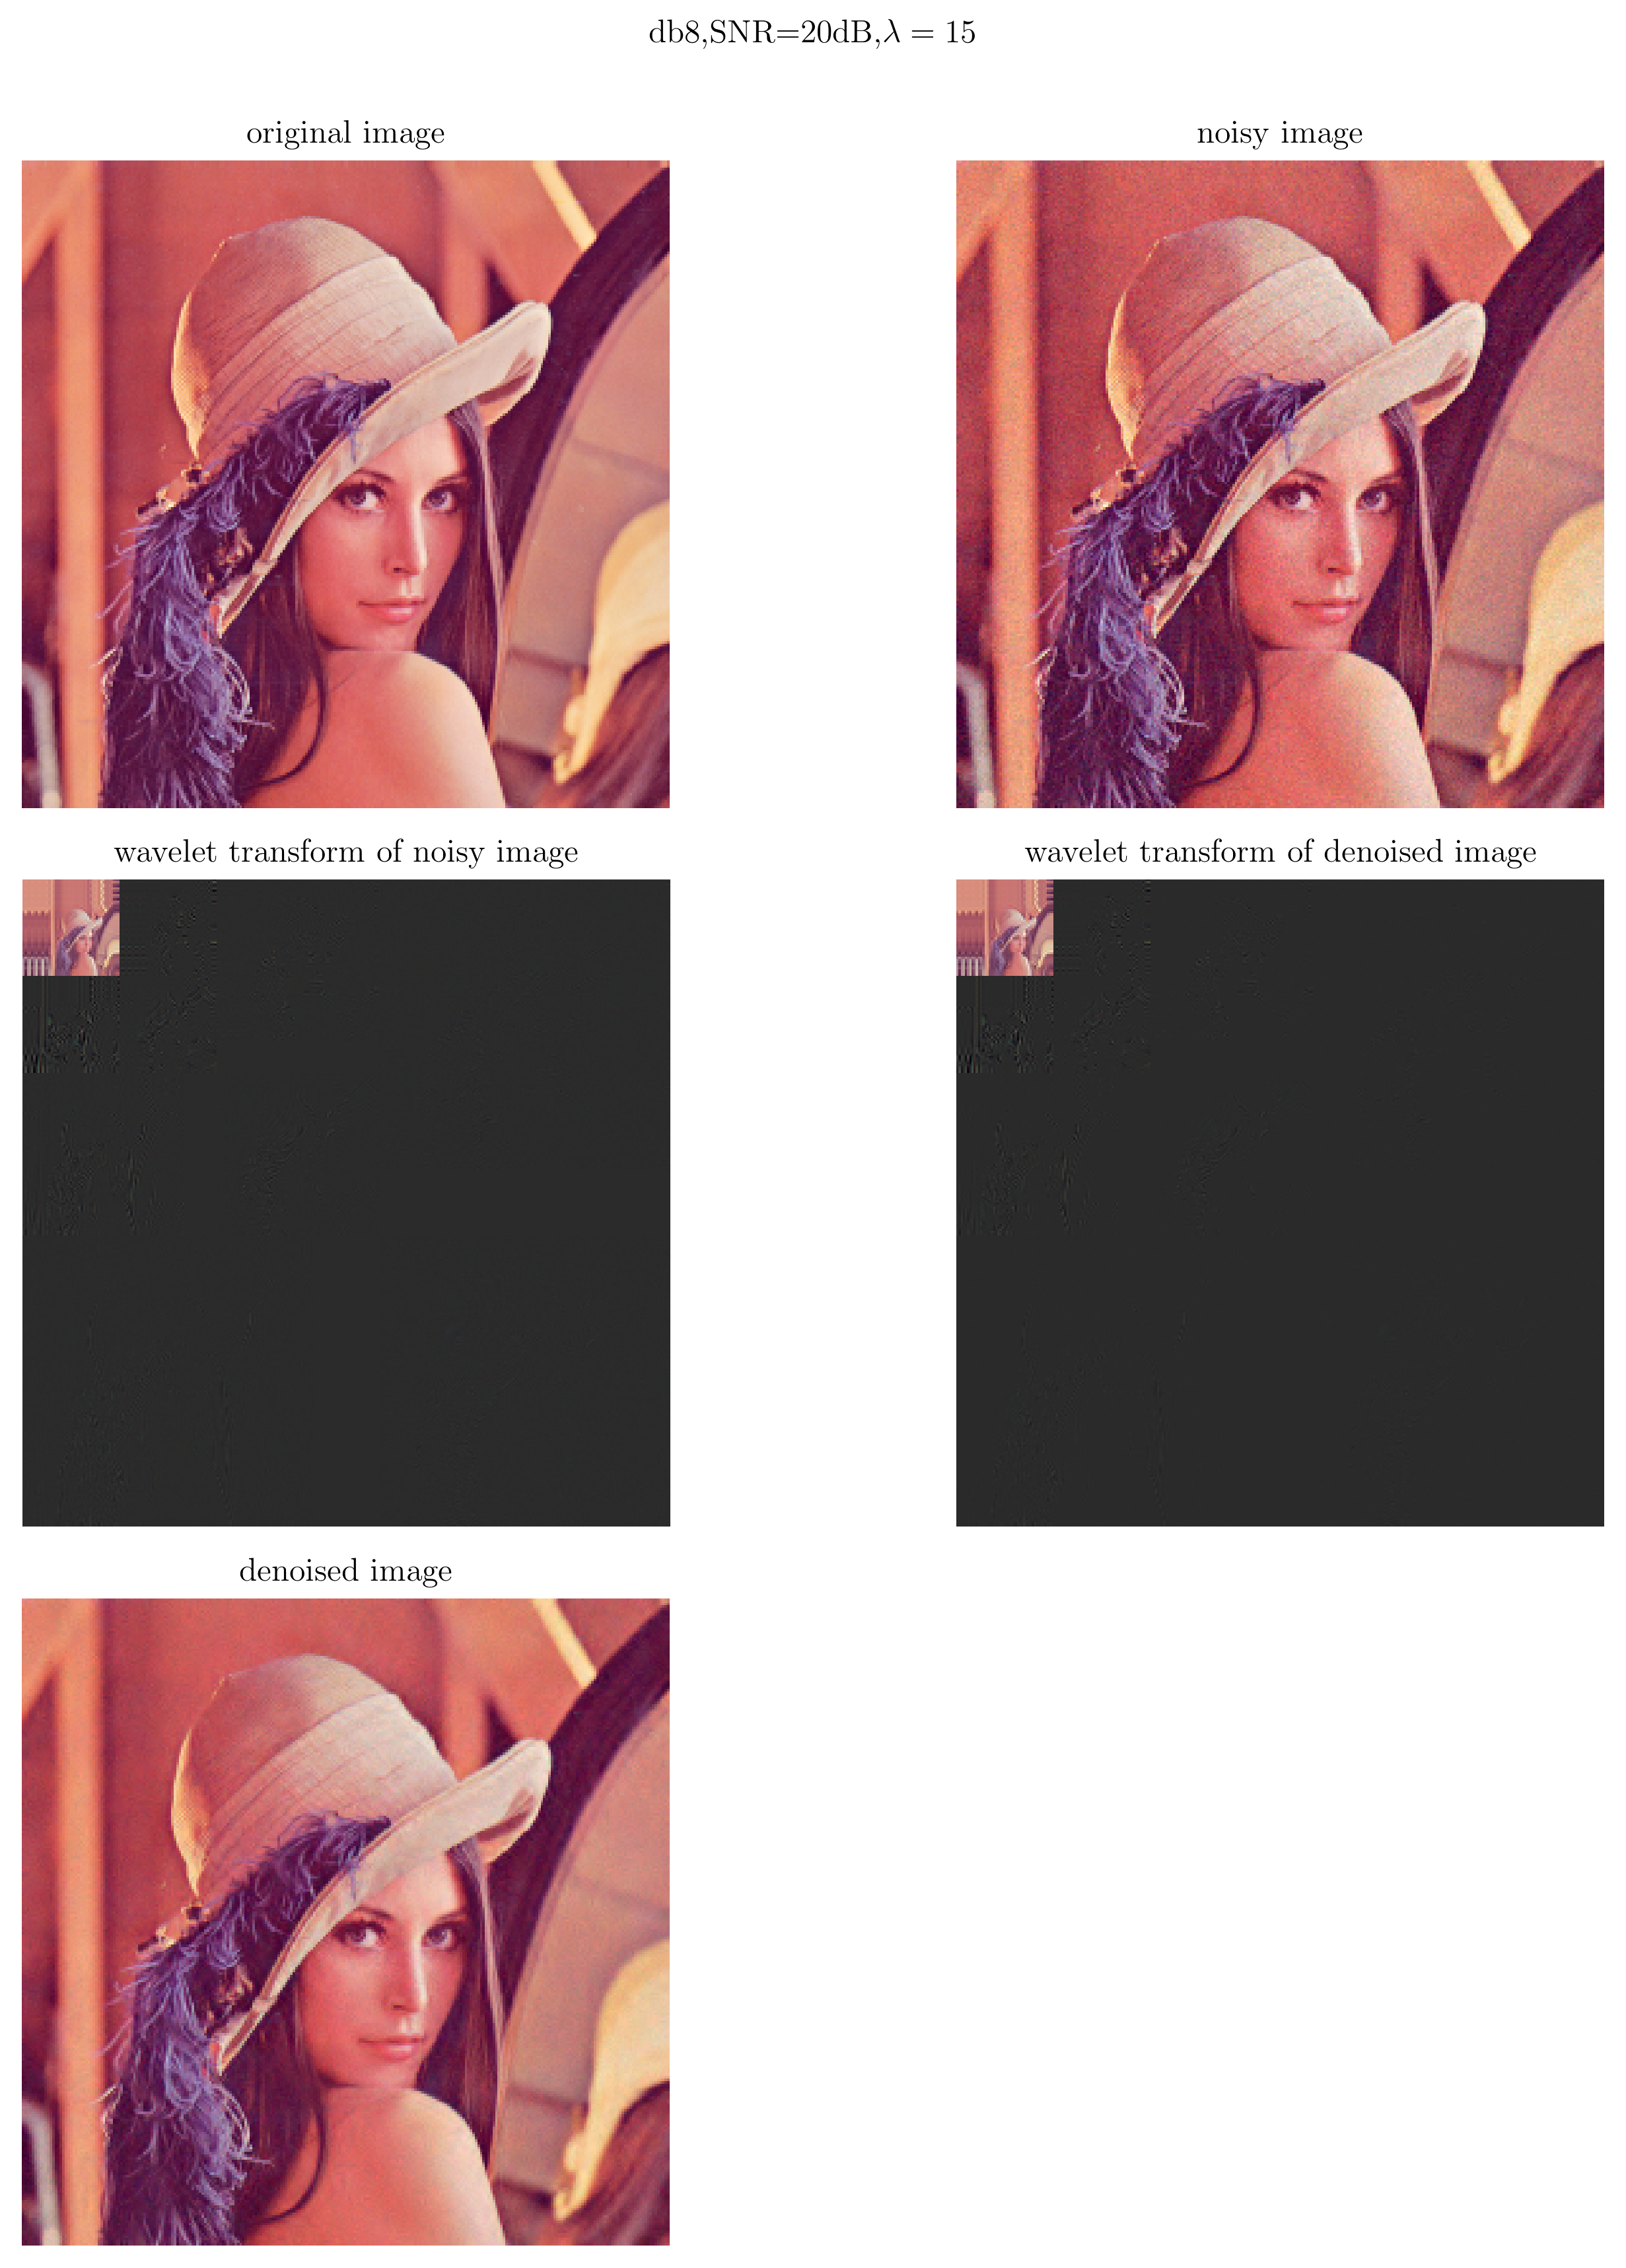

In [33]:
wl_kernel = 'db8'
level = 3

plt.figure(dpi = 300, figsize = [10,12])
plt.suptitle('db8,SNR=20dB,$\lambda=15$')
plt.subplot(321)
plt.imshow(img[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('original image')
plt.subplot(322)
plt.imshow(nimg_20[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('noisy image')

nimg_coef = forward_transform(nimg_20,wl_kernel,level)
plt.subplot(323)
plt.imshow(coef2img(nimg_coef)[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of noisy image')

deimg_coef,J_hist,_ = ISTA_w(nimg_20, wl_kernel, lamb = 15, level = level, err=1e-9, steps=1e2)
plt.subplot(324)
plt.imshow(coef2img(deimg_coef).astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('wavelet transform of denoised image')

plt.subplot(325)
denimg = inverse_transform(deimg_coef,wl_kernel)
denimg[np.where(denimg > 255)] = 255
denimg[np.where(denimg < 0)] = 0
plt.imshow(denimg.astype('uint8')[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('denoised image')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

`db8` gave the same denoising effect at `lambda=15`, and only a little blurring. Shown better effect than `haar`.